# <Center> AI VS. HUMAN: EXPLORING THE LIMITS OF MACHINE INTELLIGENCE </Center>

### <Center> GROUP E <br><br> Sai Chaitanya Pachipulusu <br> Jyothi Sai Moganti <br> Aditya Shailesh Brahme <br> Akshara Rathod Bhukya</Center>

## 1.Data Collection

#### Import statements

In [282]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
import spacy
nlp = spacy.load('en_core_web_sm')
import sys
import warnings
warnings.filterwarnings('ignore')

#### Inline print and go to the begining of line

In [2]:
def print_line(*args):
    args1 = [str(arg) for arg in args]
    str_ = ' '.join(args1)
    sys.stdout.write(str_ + '\r')
    sys.stdout.flush()

#### Converting the text into tokens, where all types of spaces and punctuation are removed

In [ ]:
def tokenize(text):
    tokens = [token.text for token in nlp(text) if not token.is_punct and not token.is_space]
    return tokens

#### Adding column to store category of questions

In [ ]:
def add_category(data, category):
    data["Category"] = category
    return data

#### Saving data as an excel file

In [ ]:
def store_excel(data, prev_data = None):
    if prev_data:
        # Loading old data into dataframe
        old_data = pd.read_excel(prev_data)
        # Concatenating the two dataframes vertically
        complete_data = pd.concat([old_data, data], ignore_index=True)
        # Storing the combined data to the excel file
        complete_data.to_excel('scraped_data_1.xlsx', index=False)
    else:
        # Storing the data to the excel file
        data.to_excel("scraped_data_1.xlsx", index=False)

### A) Scraping Data

In [ ]:
def getData(page_urls, driver, min_ans_len = 15, limit = 10, scroll_num = 10, print_every = 10):
    
    # Empty dataframe to store the scraped content
    scraped_data = pd.DataFrame()
    
    # Initializing variable to track the number of data samples collected 
    len_data = 0
    
    # Initializing lists to store the scraped content
    questions = []
    answers = []
    
    # Count for webpages
    count = 1
    # Count for data being collected
    count1 = 0
    
    for page_url in page_urls:
        print(f"Page {count} of {len(page_urls)}")
        # Sending a get request to the web page (Navigating to the webpage)
        driver.get(page_url)
        # Wait
        driver.implicitly_wait(10)

        # Initializing variables to iterate through the try except block
        max_tries = 10
        retry = 0   

        # Initializing variable to check if we've reached the end of the page 
        old_content = None
        new_content = None

        # Scrolling to get enough answers
        for i in range(scroll_num):
            # Scrolling to access the next page of questions
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            # Wait for the content to be loaded        
            time.sleep(5) 
            # Checking if page is same before and after scrolling
            new_content = driver.page_source
            if new_content == old_content:
                break
            old_content = new_content

        # Used while loop to avoid "StaleElementReferenceException" error
        while retry<max_tries:
            try:
                # Scraping the question answer blocks on Quora
                data_elements = driver.find_elements(By.CSS_SELECTOR, "div.dom_annotate_multifeed_bundle_AnswersBundle")
                retry = 0
                break
            except:
                retry += 1


        # Used while loop to avoid "StaleElementReferenceException" error
        while retry<max_tries:
            try:
                for block in data_elements:

                    ### --- Questions --- ###
                    # Scraping question from the webpage 
                    ques = block.find_element(By.CSS_SELECTOR, "div.q-text.puppeteer_test_question_title span")

                    ### --- Answers --- ###
                    # Checking if "more" button is present for an answer
                    try: 
                        # Selecting the "more" button
                        read_more = block.find_element(By.CSS_SELECTOR, "div.q-absolute div.qt_read_more")
                        # Checking if the button is clickable
                        try:
                            # Expanding answer by clicking "more" button
                            read_more.click()
                        except:
                            # Discarding data where complete answer cannot be obtained
                            continue
                    except:
                        None
                    # Scraping answers from the webpage 
                    ans = block.find_element(By.CSS_SELECTOR, "div.q-box.spacing_log_answer_content.puppeteer_test_answer_content span.q-box")

                    if ques.text and ans.text:
                        # Skipping questions that are already present
                        if ques.text in questions:
                            continue
                        # Skipping the questions where length of answers are less than a given threshold
                        ans_tokens = len(tokenize(ans.text))
                        if ans_tokens<min_ans_len:
                            continue
                        # Appending the scraped question
                        questions.append(ques.text)
                        # Appending the scraped answer
                        answers.append(ans.text)
                        count1+=1
                        if count1 % print_every == 0 or count1 == limit:
                            print(f"{count1} of {limit}")
                        else:
                            print_line(f"{count1} of {limit}")
                    else:
                        continue

                    # Updating the number of data samples collected
                    len_data = len(questions) 
                    # Collecting data until limit is reached 
                    if len_data == limit:
                        break
                retry = 0
                break
            except:
                retry += 1 
        count+=1
        if len_data == limit:
            break
        
    # Warning to give more urls if desired amount of data is not scraped
    if len_data < limit:
        print("Warning: Need to provide more webpages to get desired amount of data!")
        
    # Storing the scraped information in a dataframe  
    scraped_data["Question"] = questions
    scraped_data["Answer"] = answers
    
    return scraped_data

In [ ]:
# List of webpages to scrape data
page_urls = ["https://www.quora.com/topic/Philosophy"]

# Path to locate webdriver
executable_path = ".../chromedriver"
# Initializing webdriver
driver = webdriver.Chrome(executable_path=executable_path)
# Scraping data
data = getData(page_urls, driver, min_ans_len = 15, limit = 250, scroll_num = 20)
# Closing the webdriver
driver.quit()

# Category of data scraped
category = "Philosophy"
# Adding category column to the scraped data
data = add_category(data, category)
# Provide already existing file, if any, to which data must be appended
prev_data = None
# Storing scraped data in excel file
store_excel(data,prev_data)

### B) Collecting ChatGPT Answers

In [ ]:
import openai
openai.api_key = "Your_API_Key"

In [ ]:
def get_ChatGPT_ans(questions):

    # Initializing list to store answers 
    answers = []

    # Send the questions to ChatGPT and store the responses
    for question in questions:
        response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": question}]
        )
        answer = response['choices'][0]['message']['content']
        answers.append(answer)
        
    return answers

In [ ]:
# Loading data
data = pd.read_excel("scraped_data_final.xlsx")
# Extracting questions column from data
questions = data["Question"].values
# Getting ChatGPT answers
chatgpt_ans = get_ChatGPT_ans(questions)
# Appending ChatGPT answers to data
data.insert(2, "ChatGPT Answer", chatgpt_ans)
# Storing data in excel file
data.to_excel("scraped_data_final.xlsx", index=False)

In [ ]:
data

## 2.Data Pre-Processing



In [195]:
data = pd.read_excel('scraped_data_final.xlsx')
data

,Question,Human Answer,ChatGPT Answer,Category
0,What is the best example of 'show but don't te...,Remember The Incredibles (2004).\nBuddy’s flas...,"One example of ""show but don't tell"" in movies...",Movie/TV
1,What in your opinion is the most realistic sce...,"For me, it’s this line from Avengers (2012).\n...","As an AI language model, I do not have persona...",Movie/TV
2,What are some awesome movie facts & details?,"You all have watched The Incredibles, no?\n(If...","1. In The Matrix, the code that is seen scroll...",Movie/TV
3,Have you ever made an entire movie theater laugh?,My wife did. We were watching X-men Days of Fu...,"As an AI language model, I have not physically...",Movie/TV
4,Do you think Daniel Radcliffe made a mistake w...,Short of getting arrested and imprisoned for l...,"As an AI language model, I cannot have opinion...",Movie/TV
...,...,...,...,...
995,Is the Indian dish from Kerala called Kadala C...,Kadala is a Malayali word for chickpeas (also ...,"As an AI language model, I don't have access t...",Indian Food
996,Can you eat curry dishes if you have acid refl...,My name is Carrie Herrera. I would like to sha...,It depends on the individual and the type of c...,Indian Food
997,Why are there so many restaurants serving curr...,"Yup.\nMost of the time, Japanese-style curry i...","Curry (Japanese style), also known as ""kare ra...",Indian Food
998,Can I feed my dog red curry?,Short answer: no. Dog digestive tracts aren’t ...,"As an AI language model, I don't have personal...",Indian Food


### A) Stop-Word Analysis

In [4]:
import nltk
nltk.download('stopwords')

import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### Creating category-wise dictionary for stopword frequency

In [5]:
def stopword_cat(col, category):
    for i in range(len(category)):
        cat_count = data.Category.value_counts()
        for j in range(cat_count[i]):
            lc = cat_count[i]
            basic_tokens = col[(i*lc) + j].split()
            for k in basic_tokens:
                if k in stop_words and k in stopwords_cat[i]:
                    stopwords_cat[i][k] += 1
                elif k in stop_words and k not in stopwords_cat[i]:
                    stopwords_cat[i][k] = 1
                else:
                    continue
    return stopwords_cat

#### Barh plot of top 20 frequently occured stopwords in each category

In [6]:
def plot_stopword_count(answer, category):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    for i in range(len(category)):
        stopwords_cat = stopword_cat(answer, category)
        sorted_stopwords = sorted(stopwords_cat[i].items(), key=lambda x: x[1], reverse=True)[:20]
        axs[i//2, i%2].barh(range(len(sorted_stopwords)), [val[1] for val in sorted_stopwords], color = 'cadetblue')
        axs[i//2, i%2].set_yticks(range(len(sorted_stopwords)))
        axs[i//2, i%2].set_yticklabels([val[0] for val in sorted_stopwords])
        axs[i//2, i%2].set_title(category[i])

    plt.tight_layout()
    plt.show()

Frequency plot of top 20 stop words in Human answers:



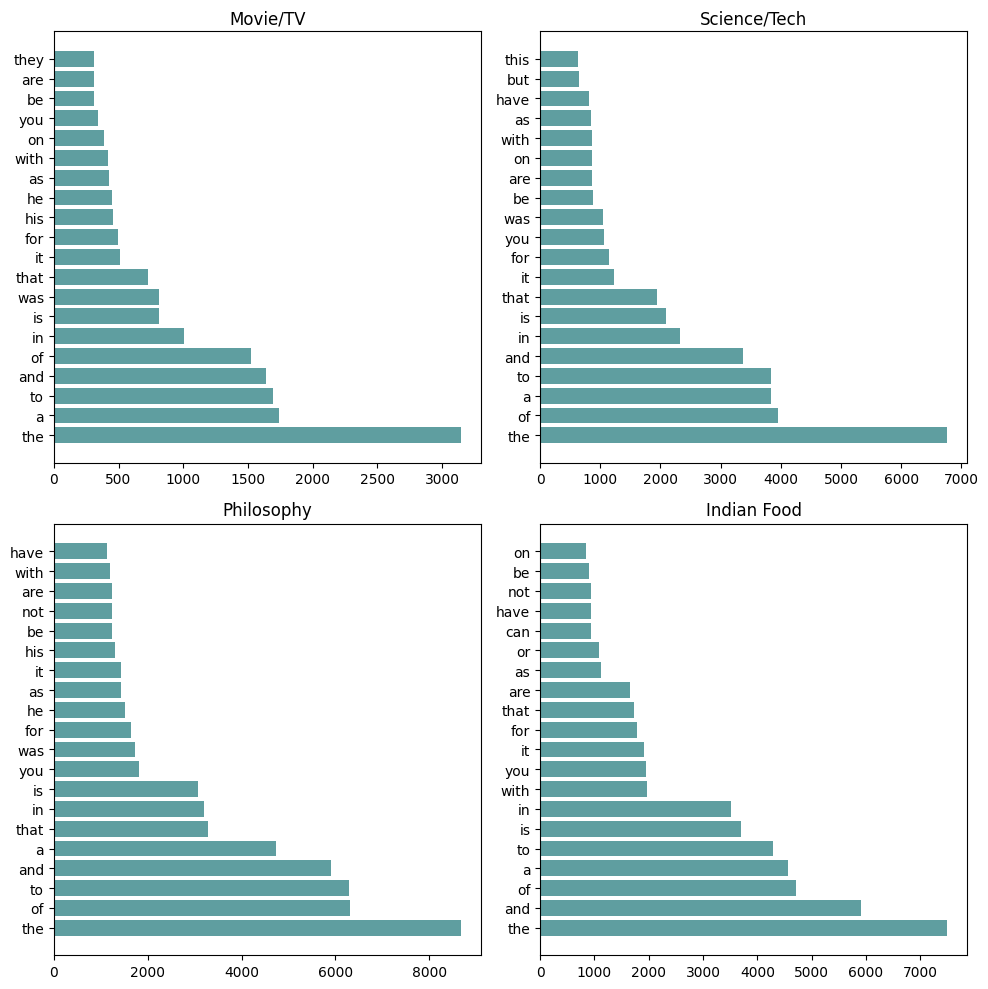



Frequency plot of top 20 stop words in ChatGPT answers:



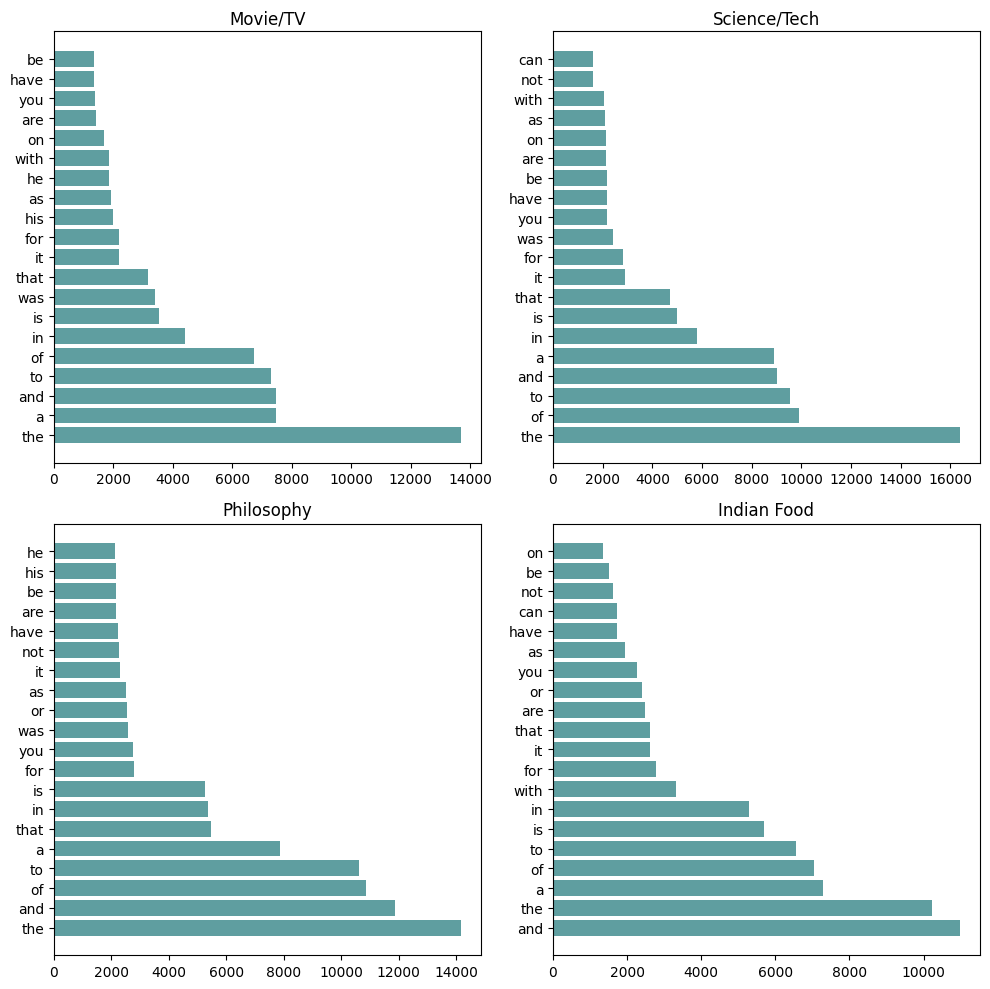

In [7]:
category = data['Category'].unique()

stopword_dict = []
stopwords_cat1, stopwords_cat2, stopwords_cat3, stopwords_cat4 = {}, {}, {}, {}
stopwords_cat = [stopwords_cat1, stopwords_cat2, stopwords_cat3, stopwords_cat4]

print("Frequency plot of top 20 stop words in Human answers:\n")
plot_stopword_count(data['Human Answer'], category)
print("\n\nFrequency plot of top 20 stop words in ChatGPT answers:\n")
plot_stopword_count(data['ChatGPT Answer'], category)

### B) Pre-processing

In [8]:
import re
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

def preprocess_data(data, remove_char_punc = True, lowercase = True, remove_stopword = True, remove_digits = True, lemmatization = True):
    if remove_char_punc:       
        # Remove Special Characters and Punctuation
        data = data.apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x))

    if lowercase:
        # Lowercasing
        data = data.apply(lambda x: x.lower())

    # Tokenization
    data = data.apply(lambda x: nltk.word_tokenize(x))

    if remove_stopword:
        # Stopword Removal
        stop_words = set(stopwords.words('english'))
        data = data.apply(lambda x: [token for token in x if token not in stop_words])

    if remove_digits:
        # Digits Removal
        data = data.apply(lambda x: [token for token in x if not token.isdigit()])

    if lemmatization:
        # Lemmatization after POS Tagging
        lemmatizer = WordNetLemmatizer()
        # POS Tagging
        data = data.apply(lambda x: nltk.pos_tag(x))
        # Mapping Penn Treebank POS tags to WordNet POS tags
        def penn_to_wordnet(tag):
            if tag.startswith('JJ'):
                return wordnet.ADJ
            elif tag.startswith('VB'):
                return wordnet.VERB
            elif tag.startswith('NN'):
                return wordnet.NOUN
            elif tag.startswith('RB'):
                return wordnet.ADV
            else:
                return wordnet.NOUN
        data = data.apply(lambda x: [(word,penn_to_wordnet(tag)) for (word,tag) in x])
        # Lemmatization
        data = data.apply(lambda x: [lemmatizer.lemmatize(word,tag) for (word,tag) in x])

    return data

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [9]:
df = data.copy()
df['Question'] = preprocess_data(df['Question'], remove_char_punc = True, lowercase = True, remove_stopword = True, remove_digits = False, lemmatization = True)
df['Human Answer'] = preprocess_data(df['Human Answer'], remove_char_punc = True, lowercase = True, remove_stopword = True, remove_digits = False, lemmatization = True)
df['ChatGPT Answer'] = preprocess_data(df['ChatGPT Answer'], remove_char_punc = True, lowercase = True, remove_stopword = True, remove_digits = False, lemmatization = True)

In [10]:
print('Question:')
for i in range(0,3):
    print('\n-Example', i)
    print('* Original: ', data['Question'].iloc[i])
    print('* Processed: ', df['Question'].iloc[i])

print('\n\nHuman Answer:')
for i in range(0,3):
    print('\n-Example', i)
    print('* Original: ', data['Human Answer'].iloc[i])
    print('* Processed: ', df['Human Answer'].iloc[i])

print('\n\nChatGPT Answer:')
for i in range(0,3):
    print('\n-Example', i)
    print('* Original: ', data['ChatGPT Answer'].iloc[i])
    print('* Processed: ', df['ChatGPT Answer'].iloc[i])

Question:

-Example 0
* Original:  What is the best example of 'show but don't tell' in movies?
* Processed:  ['best', 'example', 'show', 'tell', 'movie']

-Example 1
* Original:  What in your opinion is the most realistic scene/moment/line in a comic book movie?
* Processed:  ['opinion', 'realistic', 'scene', 'moment', 'line', 'comic', 'book', 'movie']

-Example 2
* Original:  What are some awesome movie facts & details?
* Processed:  ['awesome', 'movie', 'fact', 'detail']


Human Answer:

-Example 0
* Original:  Remember The Incredibles (2004).
Buddy’s flashback is actually different from the way it really happened.
At the beginning of the movie, Mr Incredible says: “Fly home, Buddy. I work alone”.
This is the shot:
Then later when Buddy’s mind flashes back to it, this different image is shown:
This is a subtle but impressive way of telling us that Buddy’s view of the event is distorted.
In the real scene, Mr Incredible is in a difficult position, he doesn’t want Buddy interfering wi

In [11]:
df

,Question,Human Answer,ChatGPT Answer,Category
0,"[best, example, show, tell, movie]","[remember, incredibles, 2004, buddy, flashback...","[one, example, show, tell, movie, famous, open...",Movie/TV
1,"[opinion, realistic, scene, moment, line, comi...","[line, avenger, 2012, kill, know, try, get, lo...","[ai, language, model, personal, opinion, belie...",Movie/TV
2,"[awesome, movie, fact, detail]","[watched, incredibles, know, tell, early, movi...","[1, matrix, code, see, scroll, screen, actuall...",Movie/TV
3,"[ever, make, entire, movie, theater, laugh]","[wife, watch, x, men, day, future, past, scene...","[ai, language, model, physically, interacted, ...",Movie/TV
4,"[think, daniel, radcliffe, make, mistake, work...","[short, get, arrest, imprisoned, life, give, d...","[ai, language, model, opinion, however, worth,...",Movie/TV
...,...,...,...,...
995,"[indian, dish, kerala, call, kadala, curry, k,...","[kadala, malayali, word, chickpea, also, know,...","[ai, language, model, access, every, kadala, c...",Indian Food
996,"[eat, curry, dish, acid, reflux, gerd]","[name, carrie, herrera, would, like, share, te...","[depends, individual, type, curry, dish, peopl...",Indian Food
997,"[many, restaurant, serve, curry, japanese, sty...","[yup, time, japanese, style, curry, top, choic...","[curry, japanese, style, also, know, kare, rai...",Indian Food
998,"[feed, dog, red, curry]","[short, answer, dog, digestive, tract, make, s...","[ai, language, model, personal, preference, re...",Indian Food


## 3.Exploratory Data Analysis:

### A) Average Length of Answers

In [12]:
categories=['Movie/TV','Science/Tech','Philosophy','Indian Food']

Avg_len_human_answer = []
Avg_len_chatgpt_answer = []

for category in categories:
    category_df=df[df['Category'] == category].reset_index(drop=True)
    total_length_human_answer = 0
    total_length_chatgpt_answer = 0
    for i in range(len(category_df)):
        length_human_answer = len(category_df['Human Answer'][i])
        length_chatgpt_answer = len(category_df['ChatGPT Answer'][i])
        total_length_human_answer += length_human_answer
        total_length_chatgpt_answer += length_chatgpt_answer
    Avg_len_human_answer.append(total_length_human_answer/len(category_df))
    Avg_len_chatgpt_answer.append(total_length_chatgpt_answer/len(category_df))

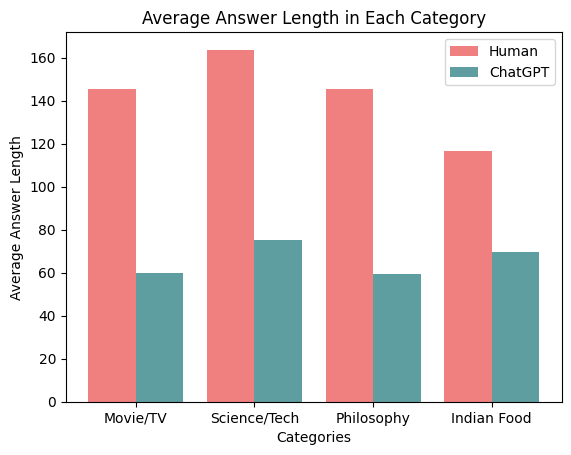

In [13]:
import numpy as np

X_axis = np.arange(len(categories))

plt.bar(X_axis - 0.2, Avg_len_human_answer, 0.4, label = 'Human', color = 'lightcoral')
plt.bar(X_axis + 0.2, Avg_len_chatgpt_answer, 0.4, label = 'ChatGPT', color = 'cadetblue')

plt.xticks(X_axis, categories)
plt.xlabel("Categories")
plt.ylabel("Average Answer Length")
plt.title("Average Answer Length in Each Category")
plt.legend()
plt.show()

### B) Lengths of Answers Histogram

In [14]:
human_ans_len = []
chatgpt_ans_len = []
for i in range(len(df)):
    human_ans_len.append(len(df['Human Answer'][i]))
    chatgpt_ans_len.append(len(df['ChatGPT Answer'][i]))

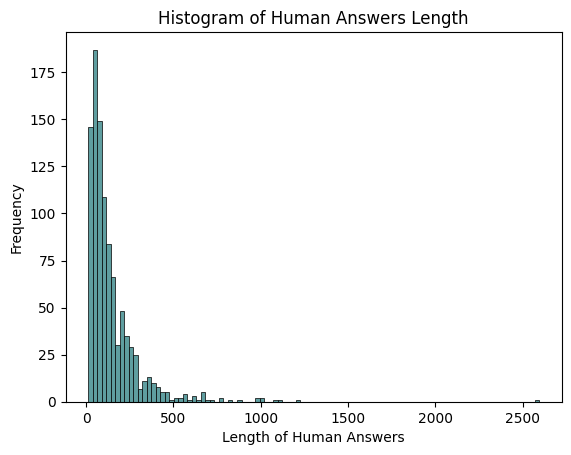

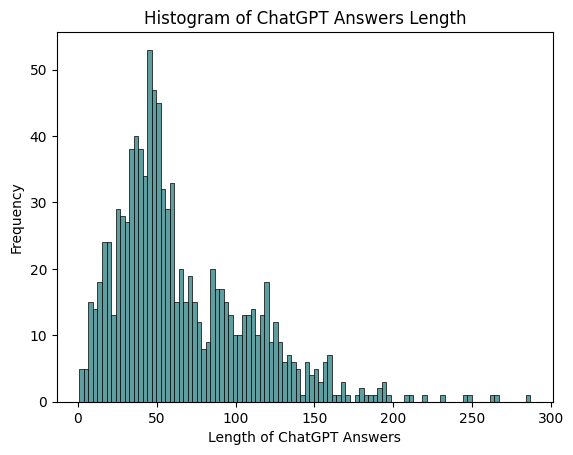

In [15]:
# Histogram of Human Answers Length
plt.hist(human_ans_len, bins = 100, facecolor = 'cadetblue', edgecolor='black', linewidth=0.5)
plt.xlabel('Length of Human Answers')
plt.ylabel('Frequency')
plt.title('Histogram of Human Answers Length')
plt.show()
print('\n\n')

# Histogram of ChatGPT Answers Length
plt.hist(chatgpt_ans_len, bins = 100, facecolor='cadetblue', edgecolor='black', linewidth=0.5)
plt.xlabel('Length of ChatGPT Answers')
plt.ylabel('Frequency')
plt.title('Histogram of ChatGPT Answers Length')
plt.show()

### C) Ratio of questions AI Model cannot answer

In [16]:
# Set of words to search for
search_words = {'ai', 'language', 'model'}

threshold = 10
# Number of rows where the list contains the search words (represents generic answers)
generic_answer = len([i for i, row in df.iterrows() if search_words.issubset(row['ChatGPT Answer']) and len(row['ChatGPT Answer']) > threshold])

# Number of rows where the list contains the search words and is a short answer (represents questions that ChatGPT cannot answer)
cannot_answer = len([i for i, row in df.iterrows() if search_words.issubset(row['ChatGPT Answer']) and len(row['ChatGPT Answer']) < threshold])

# Number of answers that the ChatGPT is able to give an answer to
answer = len(df['ChatGPT Answer']) - generic_answer - cannot_answer

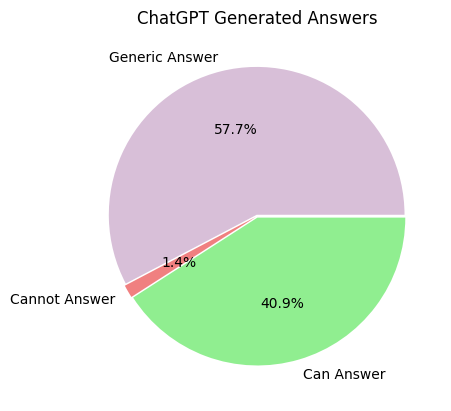

In [17]:
# Create a pie chart
plt.pie([generic_answer, cannot_answer, answer], labels = ['Generic Answer', 'Cannot Answer', 'Can Answer'], \
        autopct = '%1.1f%%', colors = ['thistle','lightcoral','lightgreen'], explode = [0.01, 0.01, 0.01])

plt.title('ChatGPT Generated Answers')
plt.show()

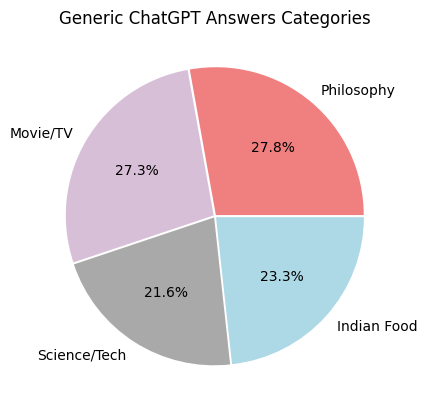

In [18]:
# Category of questions that generic ChatGPT answers
gen_answer_categories = [row['Category'] for i, row in df.iterrows() if search_words.issubset(row['ChatGPT Answer'])]
category_count = {}
for cat in set(df['Category']):
    category_count[cat] = gen_answer_categories.count(cat)

plt.pie(list(category_count.values()), labels =list(category_count.keys()), autopct='%1.1f%%', \
        colors = ['lightcoral', 'thistle', 'darkgray', 'lightblue'], explode = [0.01, 0.01, 0.01, 0.01])
plt.title('Generic ChatGPT Answers Categories')
plt.show()

### D) Word-Frequency Analysis

In [19]:
freq_dict_human = {}
freq_dict_chatgpt = {}

all_words = []
for tokens in df['Human Answer']:
    all_words += tokens

for word in all_words:
    if word in freq_dict_human:
        freq_dict_human[word] += 1
    else:
        freq_dict_human[word] = 1

all_words = []
for tokens in df['ChatGPT Answer']:
    all_words += tokens

for word in all_words:
    if word in freq_dict_chatgpt:
        freq_dict_chatgpt[word] += 1
    else:
        freq_dict_chatgpt[word] = 1

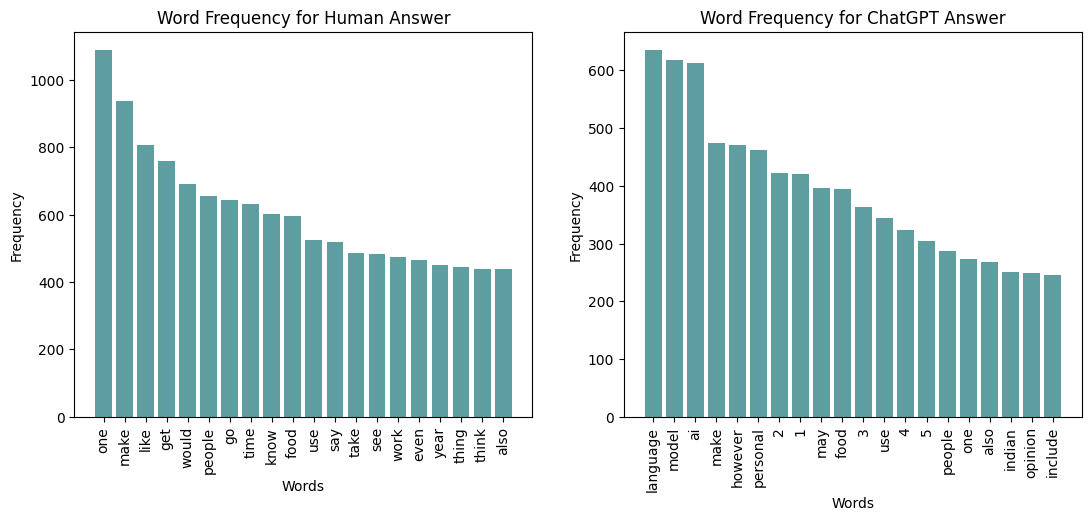

In [20]:
sorted_dict_human = {key: value for key, value in sorted(freq_dict_human.items(), key=lambda item: item[1], reverse=True)[:20]}
sorted_dict_chatgpt = {key: value for key, value in sorted(freq_dict_chatgpt.items(), key=lambda item: item[1], reverse=True)[:20]}

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

axes[0].bar(sorted_dict_human.keys(), sorted_dict_human.values(), color = 'cadetblue')
axes[0].set_title("Word Frequency for Human Answer")
axes[0].set_xlabel("Words")
axes[0].set_ylabel("Frequency")
axes[0].tick_params(axis='x', labelrotation=90)

axes[1].bar(sorted_dict_chatgpt.keys(), sorted_dict_chatgpt.values(), color = 'cadetblue')
axes[1].set_title("Word Frequency for ChatGPT Answer")
axes[1].set_xlabel("Words")
axes[1].set_ylabel("Frequency")
axes[1].tick_params(axis='x', labelrotation=90)

plt.show()

### E) Word Cloud


Word Cloud for Human Answers.



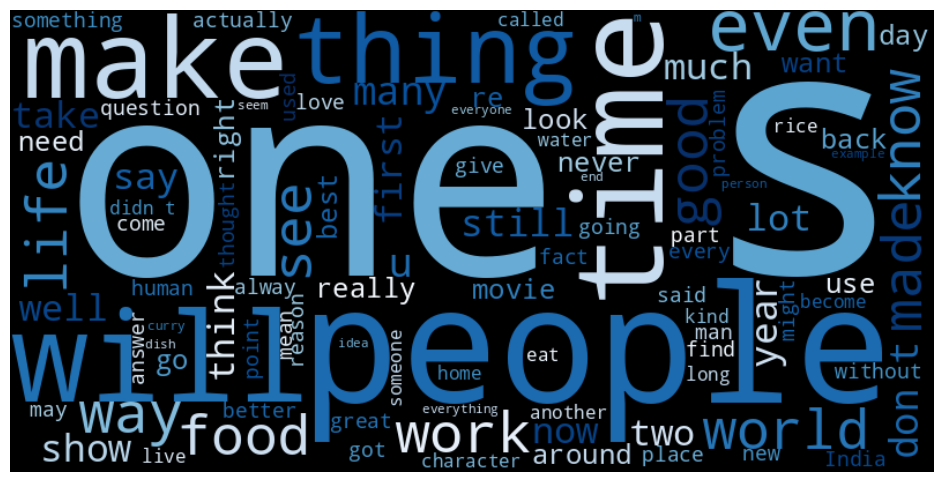



Word Cloud for ChatGPT Answers.



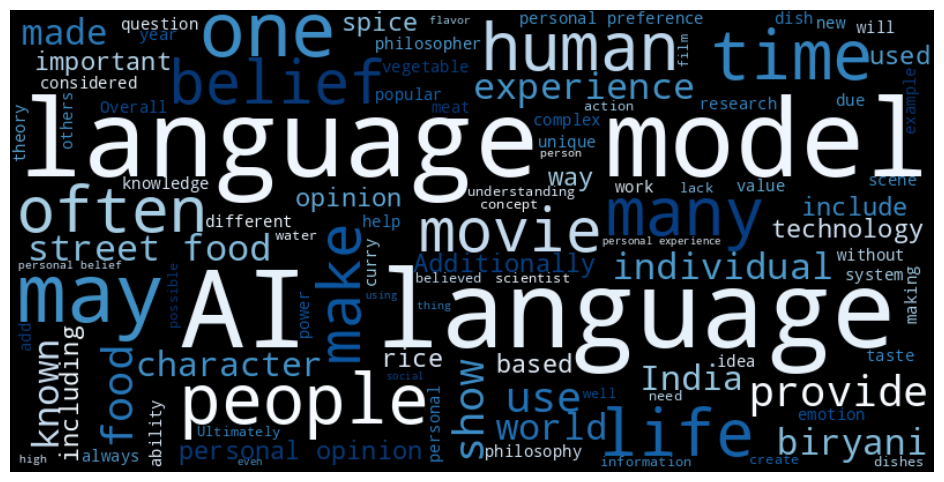

In [21]:
from wordcloud import WordCloud

human_text = ''
chatGPT_text = ''

for ans in data['ChatGPT Answer']:
    chatGPT_text += ans

for ans in data['Human Answer']:
    human_text += ans

wordcloud_human = WordCloud(width=800, height=400, background_color="black", max_words=100, colormap="Blues").generate(human_text)
wordcloud_chatGPT = WordCloud(width=800, height=400, background_color="black", max_words=100, colormap="Blues").generate(chatGPT_text)
print('\nWord Cloud for Human Answers.\n')
plt.figure(figsize=(12,6))
plt.imshow(wordcloud_human, interpolation='bilinear')
plt.axis("off")
plt.show()

print('\n\nWord Cloud for ChatGPT Answers.\n')
plt.figure(figsize=(12,6))
plt.imshow(wordcloud_chatGPT, interpolation='bilinear')
plt.axis("off")
plt.show()

### F) Sentiment Analysis

In [22]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

sentiment_scores_human = []
sentiment_scores_human = data['Human Answer'].apply(lambda x: sia.polarity_scores(x))

sentiment_scores_chatgpt = []
sentiment_scores_chatgpt = data['ChatGPT Answer'].apply(lambda x: sia.polarity_scores(x))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


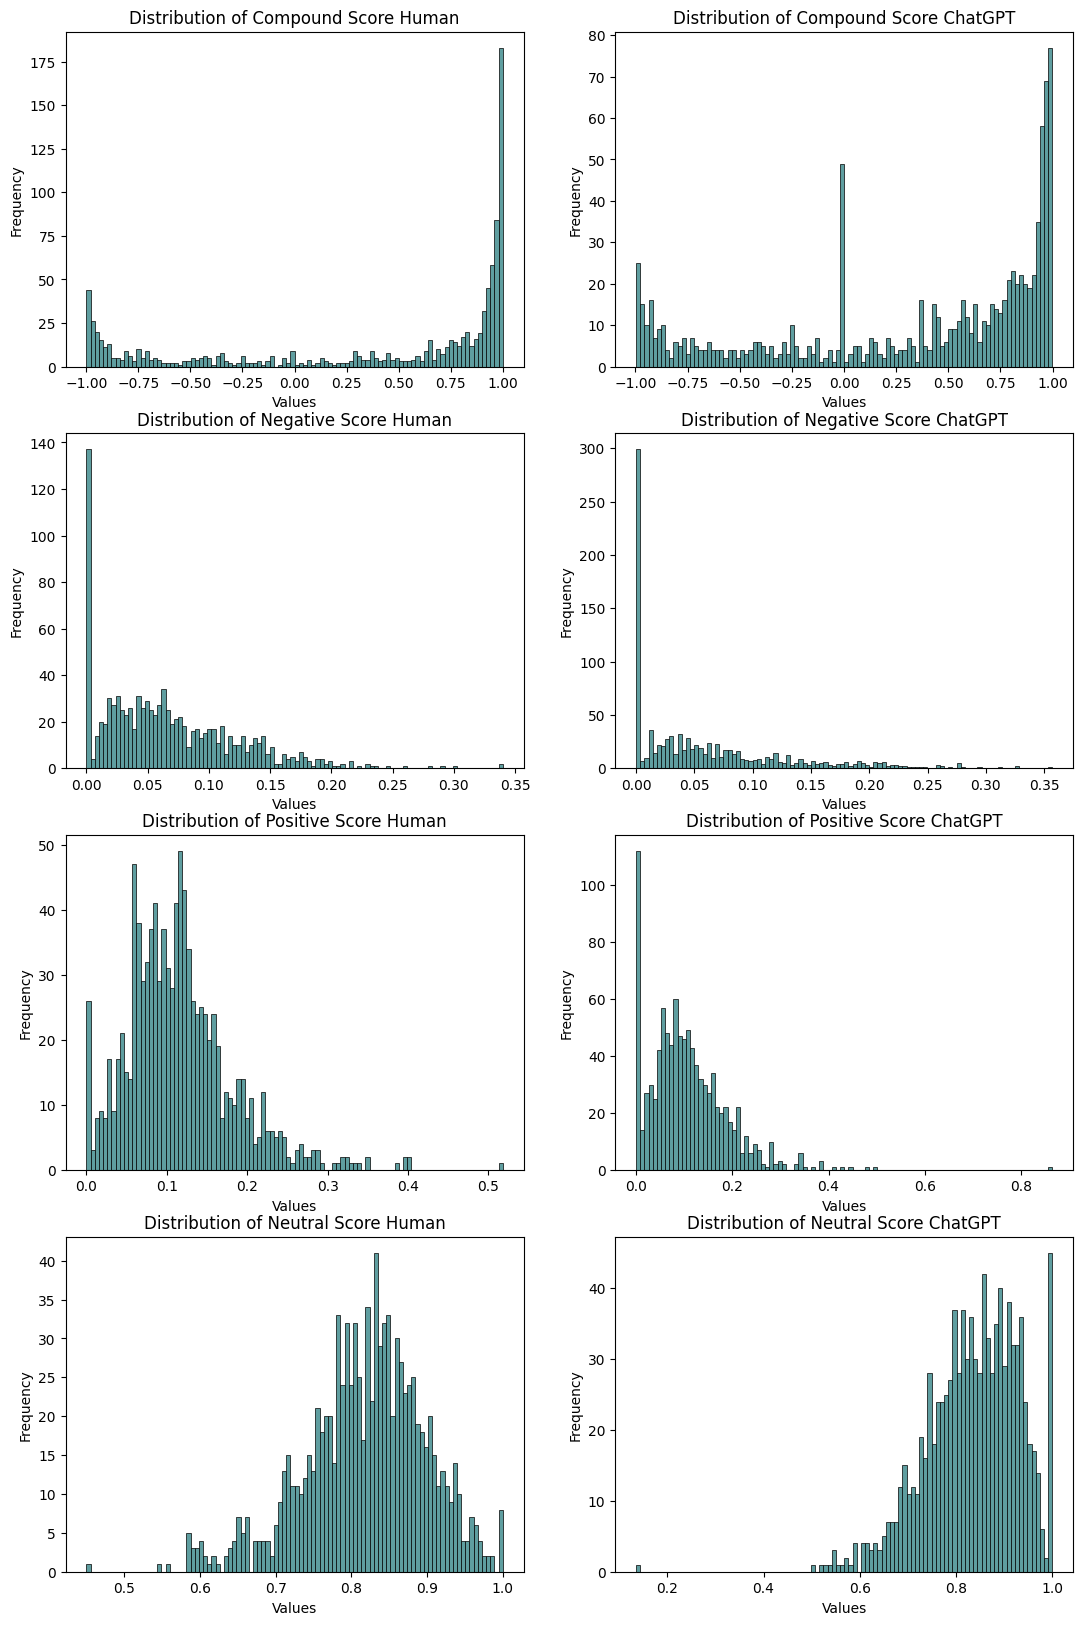

In [23]:
compound_score_human = [score['compound'] for score in sentiment_scores_human]
pos_score_human = [score['pos'] for score in sentiment_scores_human]
neg_score_human = [score['neg'] for score in sentiment_scores_human]
neu_score_human = [score['neu'] for score in sentiment_scores_human]

compound_score_chatgpt = [score['compound'] for score in sentiment_scores_chatgpt]
pos_score_chatgpt = [score['pos'] for score in sentiment_scores_chatgpt]
neg_score_chatgpt = [score['neg'] for score in sentiment_scores_chatgpt]
neu_score_chatgpt = [score['neu'] for score in sentiment_scores_chatgpt]


fig, axes = plt.subplots(4, 2, figsize=(13, 20))

#compound_score_human
axes[0,0].hist(compound_score_human, bins= 100, facecolor='cadetblue', edgecolor='black', linewidth=0.5)
axes[0,0].set_xlabel('Values')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Distribution of Compound Score Human')

# compound_score_chatgpt
axes[0,1].hist(compound_score_chatgpt, bins= 100, facecolor='cadetblue', edgecolor='black', linewidth=0.5)
axes[0,1].set_xlabel('Values')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Distribution of Compound Score ChatGPT')

# neg_score_human
axes[1,0].hist(neg_score_human, bins= 100, facecolor='cadetblue', edgecolor='black', linewidth=0.5)
axes[1,0].set_xlabel('Values')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Distribution of Negative Score Human')

# neg_score_chatgpt
axes[1,1].hist(neg_score_chatgpt, bins= 100, facecolor='cadetblue', edgecolor='black', linewidth=0.5)
axes[1,1].set_xlabel('Values')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Distribution of Negative Score ChatGPT')

# pos_score_human
axes[2,0].hist(pos_score_human, bins= 100, facecolor='cadetblue', edgecolor='black', linewidth=0.5)
axes[2,0].set_xlabel('Values')
axes[2,0].set_ylabel('Frequency')
axes[2,0].set_title('Distribution of Positive Score Human')

# pos_score_chatgpt
axes[2,1].hist(pos_score_chatgpt, bins= 100, facecolor='cadetblue', edgecolor='black', linewidth=0.5)
axes[2,1].set_xlabel('Values')
axes[2,1].set_ylabel('Frequency')
axes[2,1].set_title('Distribution of Positive Score ChatGPT')

#neu_score_human
axes[3,0].hist(neu_score_human, bins= 100, facecolor='cadetblue', edgecolor='black', linewidth=0.5)
axes[3,0].set_xlabel('Values')
axes[3,0].set_ylabel('Frequency')
axes[3,0].set_title('Distribution of Neutral Score Human')

# neu_score_chatgpt
axes[3,1].hist(neu_score_chatgpt, bins= 100, facecolor='cadetblue', edgecolor='black', linewidth=0.5)
axes[3,1].set_xlabel('Values')
axes[3,1].set_ylabel('Frequency')
axes[3,1].set_title('Distribution of Neutral Score ChatGPT')

plt.show()

## 4.Feature Engineering

### A) Grammatical Mistakes

In [24]:
import nltk
nltk.download('averaged_perceptron_tagger')

def gram_mistakes(tokens):
    
    # List to store number of grammatical mistakes
    mist = []
    
    n = len(tokens)
    
    for i in range(n):
        # POS tagging
        tagged = nltk.pos_tag(tokens[i])
        # Bigrams
        bi = list(nltk.bigrams(tagged))
        
        ### COMMON GRAMMATICAL MISTAKES ###
        
        # Preposition - Adverb pairs
        p_adv = len([(x[0],y[0]) for (x,y) in bi \
         if x[1]=='IN' and y[1]=='RB'])
        
        # Verb - Adverb pairs
        vb_adv = len([(x[0],y[0]) for (x,y) in bi \
         if x[1]=='VB' and y[1]=='RB'])     
        
        # Adverb - Adjective pairs
        adv_adj = len([(x[0],y[0]) for (x,y) in bi \
         if x[1]=='RB' and y[1]=='JJ'])
        
        # Adjective - Adjective pairs
        adj_adj = len([(x[0],y[0]) for (x,y) in bi \
         if x[1]=='JJ' and y[1]=='JJ']) 

        # Preposition - Preposition pairs
        p_p = len([(x[0],y[0]) for (x,y) in bi \
         if x[1]=='IN' and y[1]=='IN'])
        
        # Pronoun - Pronoun pairs
        pro_pro = len([(x[0],y[0]) for (x,y) in bi \
         if x[1]=='PRP' and y[1]=='PRP'])
        
        # Adverb - Adverb pairs
        adv_adv = len([(x[0],y[0]) for (x,y) in bi \
         if x[1]=='RB' and y[1]=='RB'])
        
        # Adjective - Pronoun pairs
        adj_p = len([(x[0],y[0]) for (x,y) in bi \
         if x[1]=='JJ' and y[1]=='PRP'])
        
        # Interjection - Conjunction pairs
        in_con = len([(x[0],y[0]) for (x,y) in bi \
         if x[1]=='UH' and y[1]=='IN'])

        # Ratio of total grammatical mistakes
        if len(bi)!=0:
            gram_mist = (p_adv + vb_adv + adv_adj + adj_adj + \
                        p_p + pro_pro + adv_adv + adj_p + in_con)/len(bi)*100
        else:
            gram_mist = 0
          
        # Storing ratio of grammatical mistakes
        mist.append(gram_mist)
        
    return mist

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [25]:
gram_mist_human = gram_mistakes(df['Human Answer'])
gram_mist_chatgpt = gram_mistakes(df['ChatGPT Answer'])

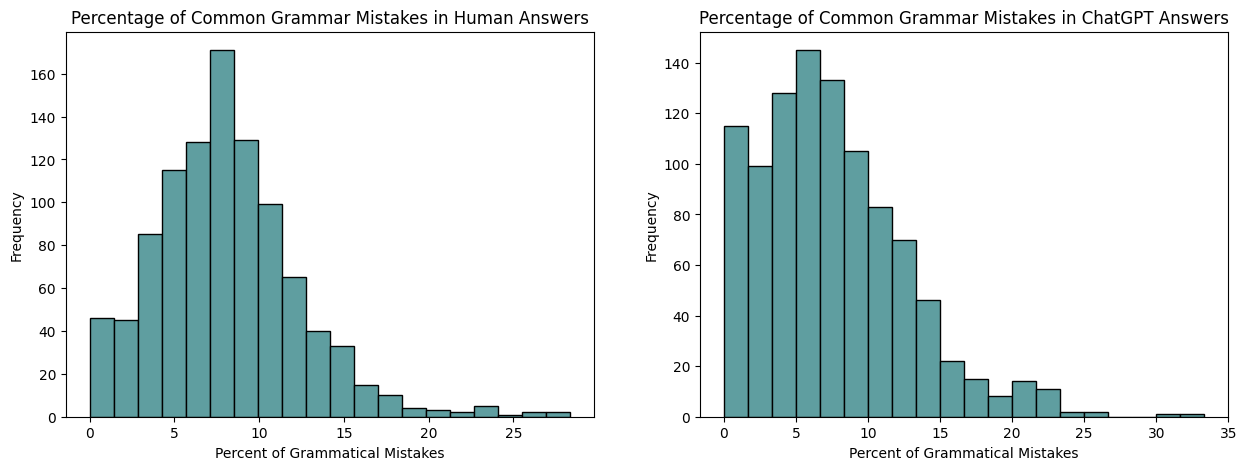

In [283]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Grammar Mistakes Human
axes[0].hist(gram_mist_human, bins= 20, facecolor='cadetblue', edgecolor='black');
axes[0].set_xlabel('Percent of Grammatical Mistakes');
axes[0].set_ylabel('Frequency');
axes[0].set_title('Percentage of Common Grammar Mistakes in Human Answers');

# Grammar Mistakes ChatGPT
axes[1].hist(gram_mist_chatgpt, bins= 20, facecolor='cadetblue', edgecolor='black');
axes[1].set_xlabel('Percent of Grammatical Mistakes');
axes[1].set_ylabel('Frequency');
axes[1].set_title('Percentage of Common Grammar Mistakes in ChatGPT Answers');

### B) Ratio of Different Parts-of-Speech

In [27]:
import nltk
nltk.download('averaged_perceptron_tagger')

def pos_ratio(tokens):
    
    # List to store ratio of various pos
    noun = []
    verb = []
    adj = []
    adv = []
    pro = []
    prep = []
    det = []
    conj = []
    inter = []

    n = len(tokens)
    
    for i in range(n):
        # POS tagging
        tagged = nltk.pos_tag(tokens[i])
        l = len(tagged)
        # Nouns
        n = len([x[0] for x in tagged if x[1].startswith('NN')])
        noun.append(n/l)

        # Verbs
        v = len([x[0] for x in tagged if x[1].startswith('VB')])
        verb.append(v/l)

        # Adjectives
        adject = len([x[0] for x in tagged if x[1].startswith('JJ')])
        adj.append(adject/l)

        # Adverbs
        ad = len([x[0] for x in tagged if x[1].startswith('RB') or x[1]=='WRB'])
        adv.append(ad/l)

        # Pronouns
        p = len([x[0] for x in tagged if x[1].startswith('PRP') or x[1].startswith('WP')])
        pro.append(p/l)

        # Prepositions
        pre = len([x[0] for x in tagged if x[1]=='IN'])
        prep.append(pre/l)

        # Determiners
        d = len([x[0] for x in tagged if x[1].endswith('DT')])
        det.append(d/l)

        # Conjunctions
        c = len([x[0] for x in tagged if x[1]=='CC'])
        conj.append(c/l)

        # Interjections
        i = len([x[0] for x in tagged if x[1]=="UH"])
        inter.append(i/l)

    return noun, verb, adj, adv, prep, det, conj, inter

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [28]:
noun_h, verb_h, adj_h, adv_h, prep_h, det_h, conj_h, inter_h = pos_ratio(df['Human Answer'])
noun_c, verb_c, adj_c, adv_c, prep_c, det_c, conj_c, inter_c = pos_ratio(df['ChatGPT Answer'])

In [29]:
pos_df_h = pd.DataFrame({"Noun":noun_h, "Verb":verb_h, "Adjective":adj_h, "Adverb":adv_h,\
                         "Preposition":prep_h, "Determiner":det_h, "Conjunction":conj_h, "Interjection":inter_h})
pos_df_c = pd.DataFrame({"Noun":noun_c, "Verb":verb_c, "Adjective":adj_c, "Adverb":adv_c,\
                         "Preposition":prep_c, "Determiner":det_c, "Conjunction":conj_c, "Interjection":inter_c})

In [30]:
pos_df_h.head()

,Noun,Verb,Adjective,Adverb,Preposition,Determiner,Conjunction,Interjection
0,0.402174,0.141304,0.271739,0.130435,0.021739,0.000000,0.0,0.000000
1,0.419048,0.247619,0.228571,0.047619,0.009524,0.009524,0.0,0.000000
2,0.409091,0.181818,0.227273,0.113636,0.000000,0.000000,0.0,0.000000
3,0.394737,0.131579,0.263158,0.131579,0.000000,0.026316,0.0,0.026316
4,0.430000,0.160000,0.205000,0.155000,0.020000,0.010000,0.0,0.000000


In [31]:
pos_df_c.head()

,Noun,Verb,Adjective,Adverb,Preposition,Determiner,Conjunction,Interjection
0,0.597015,0.104478,0.194030,0.044776,0.029851,0.0,0.0,0.0
1,0.525424,0.135593,0.237288,0.084746,0.000000,0.0,0.0,0.0
2,0.480315,0.125984,0.188976,0.070866,0.007874,0.0,0.0,0.0
3,0.588235,0.117647,0.176471,0.058824,0.000000,0.0,0.0,0.0
4,0.608696,0.065217,0.195652,0.086957,0.021739,0.0,0.0,0.0


In [32]:
column_means_h = pos_df_h.mean()
column_means_c = pos_df_c.mean()
column_means_h['Others'] = 1- sum(column_means_h)
column_means_c['Others'] = 1- sum(column_means_c)
columns = column_means_h.index
for col in columns:
    if column_means_h[col]>column_means_c[col]:
        print(f"{col} more likely to occur in human answers.")
    else:
        print(f"{col} more likely to occur in ChatGPT answers.")

Noun more likely to occur in ChatGPT answers.
Verb more likely to occur in human answers.
Adjective more likely to occur in ChatGPT answers.
Adverb more likely to occur in human answers.
Preposition more likely to occur in human answers.
Determiner more likely to occur in human answers.
Conjunction more likely to occur in human answers.
Interjection more likely to occur in human answers.
Others more likely to occur in ChatGPT answers.


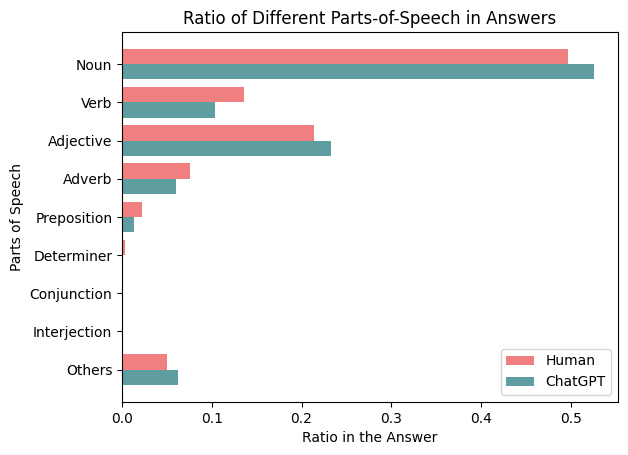

In [33]:
X_axis = np.arange(len(column_means_h))

plt.barh(X_axis - 0.2, column_means_h.values, 0.4, label = 'Human', color = 'lightcoral')
plt.barh(X_axis + 0.2, column_means_c.values, 0.4, label = 'ChatGPT', color = 'cadetblue')

plt.gca().invert_yaxis()
plt.yticks(X_axis, column_means_h.index)
plt.ylabel("Parts of Speech")
plt.xlabel("Ratio in the Answer")
plt.title("Ratio of Different Parts-of-Speech in Answers")
plt.legend()
plt.show()

## 5.Preparing Data for Classification Model

### A) Concatenate Data (Human and ChatGPT Answers)

In [284]:
# Creating a temporary dataframe by dropping the 'Human Answer' column from datafile
temporary_df1 = df.drop('Human Answer', axis=1)
# Renaming the columns of the temporary dataframe
temporary_df1.columns = ['Question','Answer','Category']
# Creating another temporary dataframe by dropping the 'ChatGPT Answer' column from datafile
temporary_df2 = df.drop('ChatGPT Answer', axis=1)
# Renaming the columns of the temporary dataframe
temporary_df2.columns = ['Question','Answer','Category']
# Combining the two temporary dataframes
classification_df = pd.concat([temporary_df1,temporary_df2],ignore_index=True)

In [285]:
# Creating target column where 0 represents ChatGPT answer and 1 represents human answer
target = [0] * len(temporary_df1) + [1] * len(temporary_df2)
# Adding a new column 'Target' to the data
classification_df['Target'] = target
classification_df

,Question,Answer,Category,Target
0,"[best, example, show, tell, movie]","[one, example, show, tell, movie, famous, open...",Movie/TV,0
1,"[opinion, realistic, scene, moment, line, comi...","[ai, language, model, personal, opinion, belie...",Movie/TV,0
2,"[awesome, movie, fact, detail]","[1, matrix, code, see, scroll, screen, actuall...",Movie/TV,0
3,"[ever, make, entire, movie, theater, laugh]","[ai, language, model, physically, interacted, ...",Movie/TV,0
4,"[think, daniel, radcliffe, make, mistake, work...","[ai, language, model, opinion, however, worth,...",Movie/TV,0
...,...,...,...,...
1995,"[indian, dish, kerala, call, kadala, curry, k,...","[kadala, malayali, word, chickpea, also, know,...",Indian Food,1
1996,"[eat, curry, dish, acid, reflux, gerd]","[name, carrie, herrera, would, like, share, te...",Indian Food,1
1997,"[many, restaurant, serve, curry, japanese, sty...","[yup, time, japanese, style, curry, top, choic...",Indian Food,1
1998,"[feed, dog, red, curry]","[short, answer, dog, digestive, tract, make, s...",Indian Food,1


### B) Concatenate Data for Neural Networks

In [286]:
# Creating a temporary dataframe by dropping the 'Human Answer' column from datafile
temporary_df1_nn = data.drop('Human Answer', axis=1)
# Renaming the columns of the temporary dataframe
temporary_df1_nn.columns = ['Question','Answer','Category']
# Creating another temporary dataframe by dropping the 'ChatGPT Answer' column from datafile
temporary_df2_nn = data.drop('ChatGPT Answer', axis=1)
# Renaming the columns of the temporary dataframe
temporary_df2_nn.columns = ['Question','Answer','Category']
# Combining the two temporary dataframes
classification_df_nn = pd.concat([temporary_df1_nn,temporary_df2_nn],ignore_index=True)

In [287]:
# Creating target column where 0 represents ChatGPT answer and 1 represents human answer
target_nn = [0] * len(temporary_df1_nn) + [1] * len(temporary_df2_nn)
# Adding a new column 'Target' to the data
classification_df_nn['Target'] = target_nn
classification_df_nn

,Question,Answer,Category,Target
0,What is the best example of 'show but don't te...,"One example of ""show but don't tell"" in movies...",Movie/TV,0
1,What in your opinion is the most realistic sce...,"As an AI language model, I do not have persona...",Movie/TV,0
2,What are some awesome movie facts & details?,"1. In The Matrix, the code that is seen scroll...",Movie/TV,0
3,Have you ever made an entire movie theater laugh?,"As an AI language model, I have not physically...",Movie/TV,0
4,Do you think Daniel Radcliffe made a mistake w...,"As an AI language model, I cannot have opinion...",Movie/TV,0
...,...,...,...,...
1995,Is the Indian dish from Kerala called Kadala C...,Kadala is a Malayali word for chickpeas (also ...,Indian Food,1
1996,Can you eat curry dishes if you have acid refl...,My name is Carrie Herrera. I would like to sha...,Indian Food,1
1997,Why are there so many restaurants serving curr...,"Yup.\nMost of the time, Japanese-style curry i...",Indian Food,1
1998,Can I feed my dog red curry?,Short answer: no. Dog digestive tracts aren’t ...,Indian Food,1


### C) Test Train Split

In [288]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_data, test_data = train_test_split(classification_df, test_size = 0.2, random_state = 42, shuffle = True)

# reset indices of train and test dataframes
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [289]:
train_data.head()

,Question,Answer,Category,Target
0,"[eat, curry]","[traditionally, curry, serve, rice, bread, naa...",Indian Food,0
1,"[sad, moment, see, movie, tv]","[ai, language, model, personal, experience, em...",Movie/TV,0
2,"[top, three, best, street, food, region, count...","[ai, language, model, specific, region, countr...",Indian Food,0
3,"[definition, happiness, possible, achieve, tot...","[definition, happiness, vary, person, person, ...",Philosophy,0
4,"[percentage, phd, thesis, groundbreaking]","[ai, language, model, accurately, estimate, pe...",Science/Tech,0


In [290]:
test_data.head()

,Question,Answer,Category,Target
0,"[street, food, vendor, consider, essential]","[sure, depend, upon, right, living, metro, wes...",Indian Food,1
1,"[great, innovative, idea]","[ai, language, model, personal, opinion, great...",Science/Tech,0
2,"[best, new, product, invention, people, know]","[panoramic, camera, ball, throw, air, reach, p...",Science/Tech,1
3,"[best, way, make, sambar]","[ai, language, model, personal, preference, ho...",Indian Food,0
4,"[dangerous, object, touch, eat, die, locate, g...","[rattlesnake, venom, believe, order, venom, ha...",Science/Tech,1


### D) Feature Matrix

In [291]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler

import scipy
from sklearn.metrics import precision_recall_fscore_support, \
classification_report, roc_curve, auc, precision_recall_curve, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm


#### Extra Features

In [292]:
def get_features(tokens):
    # Get additional features
    gram_mist = gram_mistakes(tokens)
    noun, verb, adj, adv, prep, det, conj, inter = pos_ratio(tokens)
    ans_len = []
    for i in range(len(tokens)):
        ans_len.append(len(tokens[i]))

    # Features matrix
    features = np.column_stack((gram_mist, noun, verb, adj, adv, prep, det, conj, inter, ans_len))

    # Normalized features matrix
    mm = MinMaxScaler()
    features = mm.fit_transform(features)

    return features

#### TF-IDF

In [293]:
def compute_tfidf(train_df, test_df = None, stop_words = None, min_df = 1):

    # Initializing the TfidfVectorizer
    vect = TfidfVectorizer(stop_words = stop_words, min_df = min_df)   

    # Generating tf-idf matrix
    tfidf_vect = vect.fit_transform([' '.join(doc) for doc in train_df])
    
    # Get feature names
    feature_names = vect.get_feature_names_out()
    if test_df is not None:
        # Transforming test data by the fitted TfidfVectorizer
        test_tfidf = vect.transform([' '.join(doc) for doc in test_df])
        return tfidf_vect, test_tfidf, feature_names
    else:
        return tfidf_vect, feature_names

#### Combined Features


In [294]:
def combined_features(train_df, test_df = None, stop_words = None, min_df = 1):

    # Obtaining other features
    train_features = get_features(train_df)    

    if test_df is not None:
        # Tf-idf matrix for train and test data
        tfidf_vect, test_tfidf, feature_names = compute_tfidf(train_df, test_df, stop_words = None, min_df = 1)
    else: 
        tfidf_vect, feature_names = compute_tfidf(train_df, stop_words = None, min_df = 1)

    # Combining features of train data
    train_feature_vect = scipy.sparse.hstack([tfidf_vect,train_features])
    feature_names = list(feature_names)
    feature_names = ['Word: ' + word for word in feature_names]
    feature_names.extend(['Grammar Mistakes', 'Noun Ratio', 'Verb Ratio', \
                          'Adjective Ratio', 'Adverb Ratio', 'Preposition Ratio', \
                          'Determiner Ratio', 'Conjunction Ratio', 'Interjection Ratio', 'Answer Length'])

    if test_df is not None:
        # Obtaining other features
        test_features = get_features(test_df)
        # Combining features of test data
        test_feature_vect = scipy.sparse.hstack([test_tfidf,test_features])
        return train_feature_vect, test_feature_vect, feature_names
    else:
        return train_feature_vect, feature_names

## 6.Mutual Information Test to find Importance of Features

In [295]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from matplotlib import pyplot

def mutual_info_test(X_train, y_train, k_value, X_test = None, transform_test = False):
 # configure to select all features
    fs = SelectKBest(score_func = mutual_info_classif, k = k_value)
 # learn relationship from training data
    fs.fit(X_train, y_train)
 # transform train input data
    X_train_fs = fs.transform(X_train)
 # transform test input data
    X_test_fs = None
    if transform_test and X_test:
        X_test_fs = fs.transform(X_test)

    return X_train_fs, X_test_fs, fs

In [296]:
from sklearn.metrics import mutual_info_score
import pandas as pd

feature_vect, feature_names = combined_features(classification_df['Answer'], test_df=None, stop_words=None, min_df=1)



In [297]:
 # Mutual information score for all the features
_,_,mi_scores = mutual_info_test(feature_vect, classification_df['Target'],False,'all')

# Create a pandas Series to sort the scores
sorted_scores = pd.Series(mi_scores.scores_, name='Scores', index=feature_names).sort_values(ascending=False)

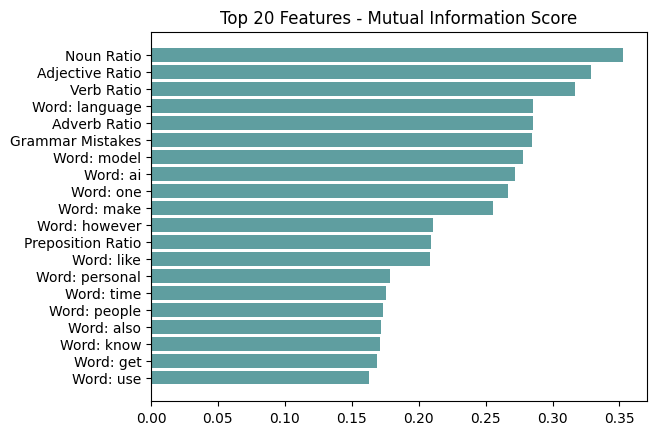

In [298]:
pyplot.barh(sorted_scores[:20].index, sorted_scores[:20].values, color = 'cadetblue')
pyplot.title("Top 20 Features - Mutual Information Score")
plt.gca().invert_yaxis()
pyplot.show()

## 7.Model Training and Evaluation

### A) Best Parameters

In [299]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB

def search_para(docs, y, model_type = 'svm'):
    
    if model_type == 'svm':
        model = svm.LinearSVC()
    elif model_type == 'nb':
        model = MultinomialNB()
    pipeline = Pipeline([('tfidf', TfidfVectorizer()), ('model', model)])
    
    parameters = {'tfidf__stop_words': [None, 'english'], 'tfidf__min_df': [1,2,3,5]}
    metric =  "f1_macro"
    gridsearch_clf = GridSearchCV(pipeline, param_grid=parameters,scoring=metric, cv=5)
    gridsearch_clf.fit([' '.join(doc) for doc in docs], y)
    final_params = {}
    for param_name in gridsearch_clf.best_params_:
        print("{0}:\t{1}".format(param_name, gridsearch_clf.best_params_[param_name]))
        final_params[param_name] = gridsearch_clf.best_params_[param_name]
    print("best f1 score: {:.3f}".format(gridsearch_clf.best_score_))
    
    return final_params


In [300]:
# Best parameters for SVM
svm_params = search_para(train_data['Answer'], train_data['Target'], model_type = 'svm')

tfidf__min_df:	2
tfidf__stop_words:	None
best f1 score: 0.906


In [301]:
# Best parameters for Naive Bayes
nb_params = search_para(train_data['Answer'], train_data['Target'], model_type = 'nb')

tfidf__min_df:	5
tfidf__stop_words:	None
best f1 score: 0.886


### B) Model Implementation - SVM and Naive Bayes

In [302]:
def create_model(train_df, train_y, test_df, test_y, model_type='svm', \
                 stop_words=None, min_df = 1, print_result = True):
    
    model, tfidf_vect, auc_score, prc_score = None, None, None, None
    
    # Feature matrix for train and test data
    train_feature_vect, test_feature_vect, feature_names = combined_features(train_df, test_df, stop_words = stop_words, min_df = min_df)

    # Train model
    if model_type=='svm':
        # Training an SVM model using the training data
        model = svm.LinearSVC().fit(train_feature_vect, train_y)
    elif model_type=='nb':
        # Training a Multinomial Naive Bayes model using the training data
        model = MultinomialNB().fit(train_feature_vect, train_y)
    
    # Predicting labels for the test data
    pred_labels = model.predict(test_feature_vect)

    # Indices of the data that were predicted incorrectly
    incorrect_indices = [i for i in range(len(test_y)) if test_y[i] != pred_labels[i]]

    # Classification report
    report = classification_report(test_y, pred_labels)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(test_y, pred_labels)

    # Probabilities as predictions
    if model_type=='svm':
        pred_y = model.decision_function(test_feature_vect)
    elif model_type=='nb':
        pred_prob = model.predict_proba(test_feature_vect)
        pred_y = pred_prob[:,1]
        
    # Computing fpr/tpr by different thresholds (positive class 1)
    fpr, tpr, thresholds = roc_curve(test_y, pred_y, pos_label=1)
    # AUC Score
    auc_score = auc(fpr, tpr)
    
    # Computing precision/recall by different thresholds (positive class 1)
    precision, recall, thresholds = precision_recall_curve(test_y, pred_y, pos_label=1)
    # PRC Score
    prc_score = auc(recall, precision)

    if print_result:
        
        # Confusion matrix
        conf_mat_plot(conf_matrix)

        # Classification report
        print(f"\nClassification Report:\n{report}")
        
    return model, tfidf_vect, auc_score, prc_score, incorrect_indices, fpr, tpr, recall, precision

In [303]:
def conf_mat_plot(cf_matrix):
    group_names = ['TN','FP','FN','TP']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                        cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    cmap = sns.cubehelix_palette(as_cmap=True)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap=cmap)
    plt.show()

SVM Model




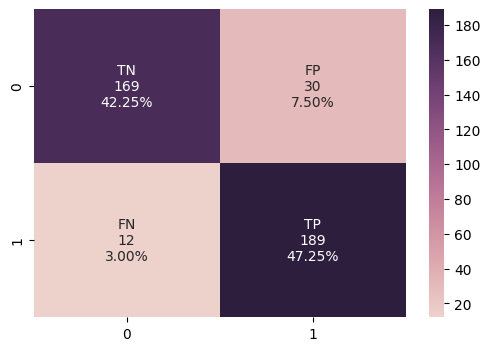


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       199
           1       0.86      0.94      0.90       201

    accuracy                           0.90       400
   macro avg       0.90      0.89      0.89       400
weighted avg       0.90      0.90      0.89       400



Naive Bayes Model




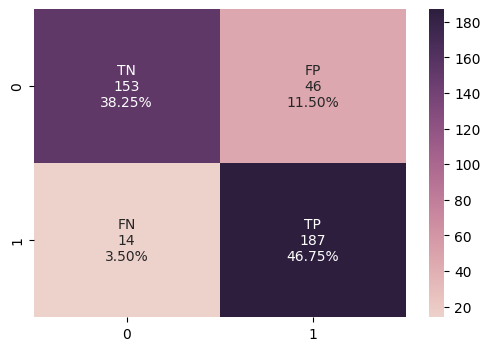


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.77      0.84       199
           1       0.80      0.93      0.86       201

    accuracy                           0.85       400
   macro avg       0.86      0.85      0.85       400
weighted avg       0.86      0.85      0.85       400



In [304]:
# Train SVM with the best parameters
print('SVM Model\n\n')
svm_model, svm_tfidf_vect, svm_auc_score, svm_prc_score, svm_incorrect_indices, svm_fpr, svm_tpr, svm_re, svm_pre = \
                                                create_model(train_data['Answer'], train_data['Target'],\
                                                test_data['Answer'], test_data['Target'],\
                                                model_type = 'svm', stop_words = svm_params['tfidf__stop_words'],\
                                                min_df = svm_params['tfidf__min_df'], print_result = True)

# Train Naive Bayes with the best parameters
print('\n\nNaive Bayes Model\n\n')
nb_model, nb_tfidf_vect, nb_auc_score, nb_prc_score, nb_incorrect_indices, nb_fpr, nb_tpr, nb_re, nb_pre = \
                                                  create_model(train_data['Answer'], train_data['Target'],\
                                                  test_data['Answer'], test_data['Target'],\
                                                  model_type = 'nb', stop_words = nb_params['tfidf__stop_words'], \
                                                  min_df = nb_params['tfidf__min_df'], print_result = True)

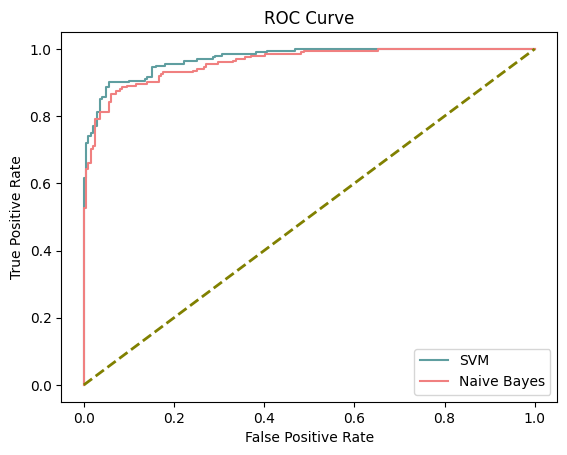


AUC of SVM: 97.14% 
AUC of Naive Bayes: 95.93%





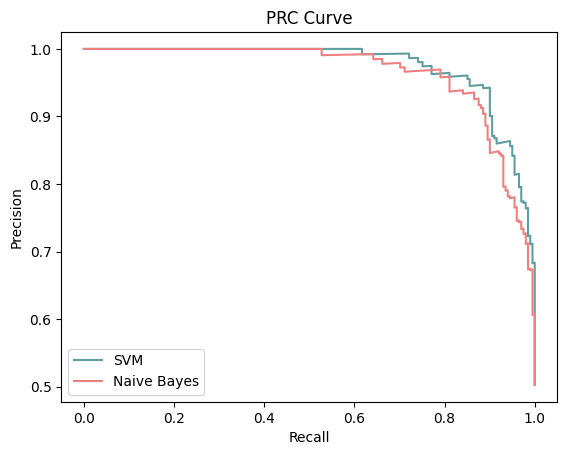


PRC of SVM: 97.44% 
PRC of Naive Bayes: 96.45%


In [305]:
# Plot ROC curves of both models
plt.plot(svm_fpr, svm_tpr, color = 'cadetblue', label = 'SVM');
plt.plot(nb_fpr, nb_tpr, color = 'lightcoral', label = 'Naive Bayes');
plt.plot([0, 1], [0, 1], color = 'olive', lw = 2, linestyle = '--');
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC Curve');
plt.legend();
plt.show();
print("\nAUC of SVM: {:.2%}".format(svm_auc_score), "\nAUC of Naive Bayes: {:.2%}".format(nb_auc_score))
print('\n\n')

# Plot PRC curves of both models
plt.figure();
plt.plot(svm_re, svm_pre, color = 'cadetblue', label = 'SVM');
plt.plot(nb_re, nb_pre, color = 'lightcoral', label = 'Naive Bayes');
plt.xlabel('Recall');
plt.ylabel('Precision');
plt.title('PRC Curve');
plt.legend();
plt.show();
print("\nPRC of SVM: {:.2%}".format(svm_prc_score), "\nPRC of Naive Bayes: {:.2%}".format(nb_prc_score))

### C) Model Implementation - Neural Networks

In [ ]:
!pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 17.5 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=78a673abba1925b897984e3ea3b9952f5d3abf07cdc61f796f9103f5a6cc9f34
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:
from sentence_transformers import SentenceTransformer

multi_lang_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

eng_lang_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')



In [ ]:
def text_embedding_func(model, data):
    embedded_text = []

    for text in data['Answer']:
        embeddings = model.encode(text)
        embedded_text.append(embeddings)
    
    return np.array(embedded_text)

In [ ]:
# Split the data into training and testing sets
train_data_nn, test_data_nn = train_test_split(classification_df_nn, test_size = 0.2, random_state = 42, shuffle = True)

# reset indices of train and test dataframes
train_data_nn = train_data_nn.reset_index(drop=True)
test_data_nn = test_data_nn.reset_index(drop=True)

# Embedding
train_eng_lang_embedding = text_embedding_func(eng_lang_model, train_data_nn) 
test_eng_lang_embedding = text_embedding_func(eng_lang_model, test_data_nn) 

In [ ]:
pd.DataFrame(train_eng_lang_embedding).to_csv('train_eng_lang_embedding', index=False)
pd.DataFrame(test_eng_lang_embedding).to_csv('test_eng_lang_embedding', index=False)


In [ ]:
# train_eng_lang_embedding = pd.read_csv('train_eng_lang_embedding', encoding='utf-8')
# test_eng_lang_embedding = pd.read_csv('test_eng_lang_embedding', encoding='utf-8')

In [ ]:
def plot_graphs(history):

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

  # plot data on the first subplot
  ax1.plot(history.history['loss'])
  ax1.plot(history.history['val_loss'])
  ax1.set_title('Model Loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.legend(['Train', 'Validation'], loc='upper right')

  # plot data on the second subplot
  ax2.plot(history.history['accuracy'])
  ax2.plot(history.history['val_accuracy'])
  ax2.set_title('Model accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('accuracy')
  ax2.legend(['Train', 'Validation'], loc='upper right')

  # display the plot
  plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras import regularizers

In [ ]:
model2 = Sequential([
    BatchNormalization(),
    Dense(512, activation='relu', kernel_regularizer = l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(32, activation='relu', kernel_regularizer = l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(8, activation='relu', kernel_regularizer = l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

# Compile the model
optimizer = Adam(learning_rate=0.0005)
model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history2 = model2.fit(train_eng_lang_embedding, np.array(train_data_nn['Target']), batch_size=16, epochs=60, validation_split=0.2)

Epoch 1/60
80/80 [==============================] - 2s 11ms/step - loss: 1.3881 - accuracy: 0.6562 - val_loss: 1.3711 - val_accuracy: 0.4563
Epoch 2/60
80/80 [==============================] - 1s 8ms/step - loss: 1.2283 - accuracy: 0.7219 - val_loss: 1.3463 - val_accuracy: 0.4969
Epoch 3/60
80/80 [==============================] - 1s 8ms/step - loss: 1.1389 - accuracy: 0.7875 - val_loss: 1.2846 - val_accuracy: 0.5562
Epoch 4/60
80/80 [==============================] - 1s 10ms/step - loss: 1.1266 - accuracy: 0.7711 - val_loss: 1.1771 - val_accuracy: 0.6906
Epoch 5/60
80/80 [==============================] - 1s 13ms/step - loss: 1.0467 - accuracy: 0.8250 - val_loss: 1.0789 - val_accuracy: 0.8000
Epoch 6/60
80/80 [==============================] - 1s 14ms/step - loss: 1.0396 - accuracy: 0.8289 - val_loss: 1.0097 - val_accuracy: 0.8313
Epoch 7/60
80/80 [==============================] - 1s 14ms/step - loss: 0.9864 - accuracy: 0.8500 - val_loss: 0.9683 - val_accuracy: 0.8625
Epoch 8/60
80/8

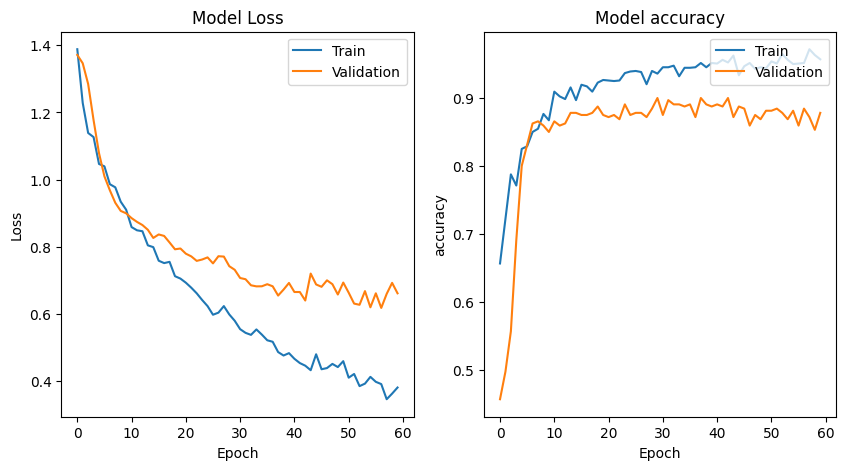

In [ ]:
plot_graphs(history2)

In [ ]:
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_24 (Bat  (None, 768)              3072      
 chNormalization)                                                
                                                                 
 dense_26 (Dense)            (None, 512)               393728    
                                                                 
 batch_normalization_25 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_20 (Dropout)        (None, 512)               0         
                                                                 
 dense_27 (Dense)            (None, 32)                16416     
                                                                 
 batch_normalization_26 (Bat  (None, 32)              

In [ ]:
# Prediction for test data
y_pred = model2.predict(test_eng_lang_embedding)

13/13 [==============================] - 0s 3ms/step


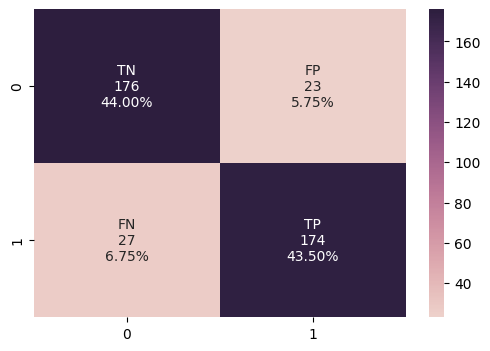

              precision    recall  f1-score   support

           0       0.87      0.88      0.88       199
           1       0.88      0.87      0.87       201

    accuracy                           0.88       400
   macro avg       0.88      0.88      0.87       400
weighted avg       0.88      0.88      0.87       400



In [ ]:
y_pred = (y_pred > 0.5).astype(int)
conf_mat_plot(confusion_matrix(test_data_nn['Target'], y_pred))

report = classification_report(test_data_nn['Target'], y_pred)
print(report)

## 8.Similarity between Human and ChatGPT answers

### A) Cosine Similarity

In [49]:
from sklearn.metrics.pairwise import cosine_similarity

def assess_similarity(human_vect, chatgpt_vect):
    result = None
    
    sim = []

    for i in range(human_vect.shape[0]):
        doc1 = human_vect[i,:]
        doc2 = chatgpt_vect[i,:]
        sim.append(cosine_similarity(doc1.reshape(1, -1), doc2.reshape(1, -1))[0][0])
        
    return sim

In [50]:
tf_idf_cos_sim, feature_names_cos_sim = compute_tfidf(classification_df['Answer'])
k_cos_sim = int(len(classification_df['Answer'])/2)
tf_idf_human_cos_sim = tf_idf_cos_sim[:k_cos_sim,:]
tf_idf_chatgpt_cos_sim = tf_idf_cos_sim[k_cos_sim:,:]
cos_sim = assess_similarity(tf_idf_human_cos_sim, tf_idf_chatgpt_cos_sim)

### B) BLEU Score

In [51]:
from nltk.translate.bleu_score import sentence_bleu

def blue_score_func(answers):
    
    k = int(len(answers)/2)
    human_ans = answers[:k]
    chatgpt_ans = answers[k:]
    
    bleuScore = []
    
    for i in range(k):
        ans1 = human_ans.iloc[i].split()
        ans2 = chatgpt_ans.iloc[i].split()
        bleuScore.append(sentence_bleu(ans1, ans2, weights=(1, 0, 0, 0)))

    return bleuScore

In [52]:
bleu_scores = blue_score_func(classification_df_nn['Answer'])

In [308]:
similarity_df = data.copy()
similarity_df['Cosine Similarity'] = cos_sim 
similarity_df['BLEU Score'] = bleu_scores 
similarity_df

,Question,Human Answer,ChatGPT Answer,Category,Cosine Similarity,BLEU Score
0,What is the best example of 'show but don't te...,Remember The Incredibles (2004).\nBuddy’s flas...,"One example of ""show but don't tell"" in movies...",Movie/TV,0.047971,0.011696
1,What in your opinion is the most realistic sce...,"For me, it’s this line from Avengers (2012).\n...","As an AI language model, I do not have persona...",Movie/TV,0.024407,0.012605
2,What are some awesome movie facts & details?,"You all have watched The Incredibles, no?\n(If...","1. In The Matrix, the code that is seen scroll...",Movie/TV,0.020401,0.030000
3,Have you ever made an entire movie theater laugh?,My wife did. We were watching X-men Days of Fu...,"As an AI language model, I have not physically...",Movie/TV,0.000000,0.016393
4,Do you think Daniel Radcliffe made a mistake w...,Short of getting arrested and imprisoned for l...,"As an AI language model, I cannot have opinion...",Movie/TV,0.191103,0.009281
...,...,...,...,...,...,...
995,Is the Indian dish from Kerala called Kadala C...,Kadala is a Malayali word for chickpeas (also ...,"As an AI language model, I don't have access t...",Indian Food,0.540830,0.028571
996,Can you eat curry dishes if you have acid refl...,My name is Carrie Herrera. I would like to sha...,It depends on the individual and the type of c...,Indian Food,0.190408,0.022901
997,Why are there so many restaurants serving curr...,"Yup.\nMost of the time, Japanese-style curry i...","Curry (Japanese style), also known as ""kare ra...",Indian Food,0.270478,0.008475
998,Can I feed my dog red curry?,Short answer: no. Dog digestive tracts aren’t ...,"As an AI language model, I don't have personal...",Indian Food,0.265317,0.025000


### C) Similarity Analysis

In [54]:
# Average Similarity
similarity_df['Cosine Similarity'].mean()

0.17423978275251525

In [55]:
# Average similarity for each category
average_cat_sim = similarity_df.groupby('Category')['Cosine Similarity'].mean()
average_cat_sim

Category
Indian Food     0.230974
Movie/TV        0.124341
Philosophy      0.177844
Science/Tech    0.163800
Name: Cosine Similarity, dtype: float64

In [56]:
# Maximum similarity for each category
max_cat_sim = similarity_df.groupby('Category')['Cosine Similarity'].max()
max_cat_sim

Category
Indian Food     0.741232
Movie/TV        0.679459
Philosophy      0.731417
Science/Tech    0.631440
Name: Cosine Similarity, dtype: float64

In [57]:
# Minimum similarity for each category
min_cat_sim = similarity_df.groupby('Category')['Cosine Similarity'].min()
min_cat_sim

Category
Indian Food     0.0
Movie/TV        0.0
Philosophy      0.0
Science/Tech    0.0
Name: Cosine Similarity, dtype: float64

In [58]:
threshold = similarity_df['Cosine Similarity'].mean()
# Similarities less than the threshold
less_than_threshold = similarity_df.groupby('Category')['Cosine Similarity'].apply(lambda x: (x < threshold).sum())
print(less_than_threshold)

Category
Indian Food      99
Movie/TV        188
Philosophy      139
Science/Tech    161
Name: Cosine Similarity, dtype: int64


In [59]:
# Number of answers with 0 similarity
less_than_threshold = similarity_df.groupby('Category')['Cosine Similarity'].apply(lambda x: (x == 0).sum())
print(less_than_threshold)

Category
Indian Food      5
Movie/TV        23
Philosophy      14
Science/Tech    10
Name: Cosine Similarity, dtype: int64


In [60]:
# Sorting DataFrame based on Cosine Similarity in descending order
similarity_df_sorted = similarity_df.sort_values(by = 'Cosine Similarity', ascending = False)
top_n = similarity_df_sorted[['Question', 'Human Answer', 'ChatGPT Answer', 'Category']]

In [61]:
# Top 10 Questions and their category, with most similar answers 
for index, row in top_n.head(10).iterrows():
    print(f"Question: {row['Question']}\nCategory: {row['Category']}\nHuman Answer: {row['Human Answer']}\nChatGPT Answer: {row['ChatGPT Answer']}\n\n\n")

Question: Can we cook lamb biriyani without oil?
Category: Indian Food
Human Answer: Yes, it is possible to cook lamb biryani without oil, although the dish may be slightly different in taste and texture compared to the traditional recipe.
One way to cook lamb biryani without oil is to use a non-stick pan and sauté the onions, spices, and lamb in a small amount of water or vegetable broth instead of oil. You can also add some yogurt or tomato paste to help create a flavorful base for the dish. Additionally, you can use brown rice or quinoa instead of white rice to make the dish healthier.
Keep in mind that using less oil may affect the texture and flavor of the dish, so you may need to experiment with the recipe to get the desired taste and consistency.
ChatGPT Answer: It is possible to cook lamb biriyani without oil, but it may not have the same texture, flavor, or appearance as a more traditional recipe. To avoid using oil, you can try using vegetable or chicken broth instead to cook

In [62]:
# Top 10 Questions and their category, with least similar answers 
for index, row in top_n.tail(10).iterrows():
    print(f"Question: {row['Question']}\nCategory: {row['Category']}\nHuman Answer: {row['Human Answer']}\nChatGPT Answer: {row['ChatGPT Answer']}\n\n\n")

Question: What are your favourite moments in Naruto Shippuden?
Category: Movie/TV
Human Answer: I’ve got a lot of them
But I can only remember one at the moment:
For those who don’t know,
Might Guy forgets the names of everyone he meets short-term.
While he saw Kisame a couple times, they weren’t enough for him to remember his name.
But after Kisame negged his tongue and then his life, just to protect the vital information of his “organization”, Guy respected and acknowledged him.
As did I.
I’m going to constantly update this answer so feel free to bookmark it or something.
Thanks for reading♠️
ChatGPT Answer: As an AI language model, I do not have personal preferences or emotions.



Question: What are some things that literally make no sense?
Category: Philosophy
Human Answer: English Pronunciations:
Mint = mint
Tint = tint
Pint = PIE-NT?
There is 0 consistency sometimes.
Rough = ruff
Cough = koff
Though = thoh
Through = throo
Tear (crying) = teer
Tear (ripping) = tayer.
Sea = see
Se

### D) Capabilities and Limitations of ChatGPT

#### Category-wise Capability/Limitation of ChatGPT to Answer Similar to Human

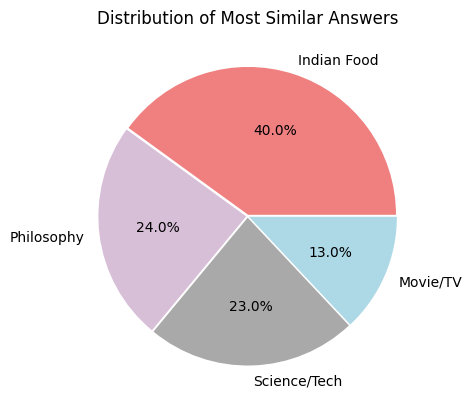

In [242]:
# Category with highest similarity questions
highest_sim = top_n.head(100)['Category'].value_counts()

# Create a pie chart
plt.pie(highest_sim.values, labels = highest_sim.index, autopct = '%1.1f%%', \
        colors = ['lightcoral', 'thistle', 'darkgray', 'lightblue'], explode = [0.01, 0.01, 0.01, 0.01])

plt.title('Distribution of Most Similar Answers')
plt.show()

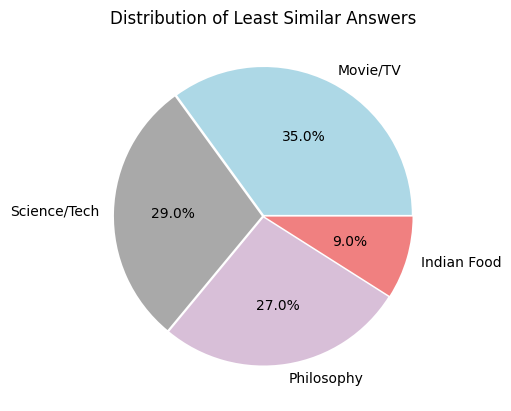

In [244]:
# Category with least similarity questions
highest_sim = top_n.tail(100)['Category'].value_counts()

# Create a pie chart
plt.pie(highest_sim.values, labels = highest_sim.index, autopct = '%1.1f%%', \
        colors = ['lightblue', 'darkgray', 'thistle', 'lightcoral'], explode = [0.01, 0.01, 0.01, 0.01])

plt.title('Distribution of Least Similar Answers')
plt.show()

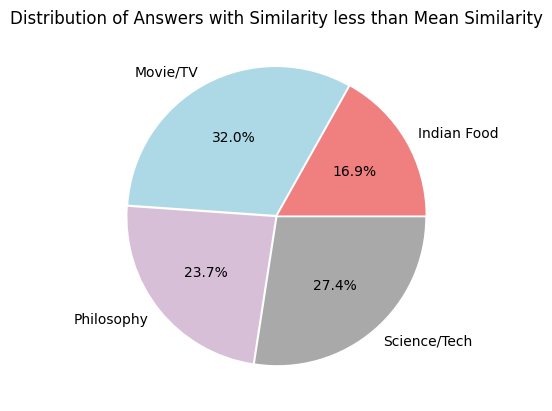

In [307]:
threshold = similarity_df['Cosine Similarity'].mean()
# Similarities less than the threshold
less_than_threshold = similarity_df.groupby('Category')['Cosine Similarity'].apply(lambda x: (x < threshold).sum())

# Create a pie chart
plt.pie(less_than_threshold.values, labels = less_than_threshold.index, autopct = '%1.1f%%', \
        colors = ['lightcoral', 'lightblue', 'thistle', 'darkgray'], explode = [0.01, 0.01, 0.01, 0.01])

plt.title('Distribution of Answers with Similarity less than Mean Similarity')
plt.show()

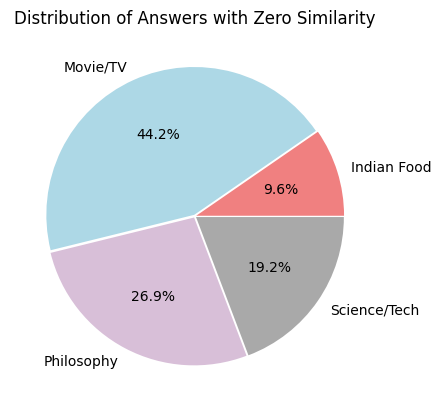

In [246]:
# Similarities less than the threshold
zero_sim = similarity_df.groupby('Category')['Cosine Similarity'].apply(lambda x: (x == 0).sum())

# Create a pie chart
plt.pie(zero_sim.values, labels = zero_sim.index, autopct = '%1.1f%%', \
        colors = ['lightcoral', 'lightblue', 'thistle', 'darkgray'], explode = [0.01, 0.01, 0.01, 0.01])

plt.title('Distribution of Answers with Zero Similarity')
plt.show()

#### Comparison of Lengths for the Most Similar and Least Similar Answers

In [223]:
top100_indices = top_n.head(100).index
top100_df = data.iloc[top100_indices]
top100_df = top100_df.reset_index(drop = True)
top100_df.head()

,Question,Human Answer,ChatGPT Answer,Category
0,Can we cook lamb biriyani without oil?,"Yes, it is possible to cook lamb biryani witho...",It is possible to cook lamb biriyani without o...,Indian Food
1,Is online dating worth it?,Whether online dating is worth it depends on v...,"As an AI language model, I cannot provide pers...",Philosophy
2,Why does Thanos respect Tony Stark so much in ...,Thanos recognized Tony Stark on sight when the...,Thanos respects Tony Stark because he recogniz...,Movie/TV
3,Who displayed a higher level of intellect in t...,Comparing the intelligence of two people is su...,"As an AI language model, I cannot assess who h...",Philosophy
4,Is biryani rice and basmati rice the same?,The questioner is confused.\nBasmati is a type...,Biryani rice is usually made using basmati ric...,Indian Food


In [224]:
low100_indices = top_n.tail(100).index
low100_df = data.iloc[low100_indices]
low100_df = low100_df.reset_index(drop = True)
low100_df.head()

,Question,Human Answer,ChatGPT Answer,Category
0,What is a job most people don't know exists?,I once visited one of my grade school friends ...,One job that most people may not know exists i...,Science/Tech
1,What is the best movie theory ever?,"Phineas and Ferb is a Disney Cartoon series, b...","As an AI language model, I can't have an opini...",Movie/TV
2,What are some of the cool historical facts som...,"Blog\nYou are about to purchase the items, do ...",Here are some cool historical facts that some ...,Science/Tech
3,What movie or TV show seems completely messed ...,Murder by Death 1976\nAs you can see by the pi...,"The TV show ""Black Mirror"" seems completely me...",Movie/TV
4,Who in actual history has ever made scientific...,Curt Herzstark\ndeveloped the best mechanical ...,While there are many scientists who have made ...,Science/Tech


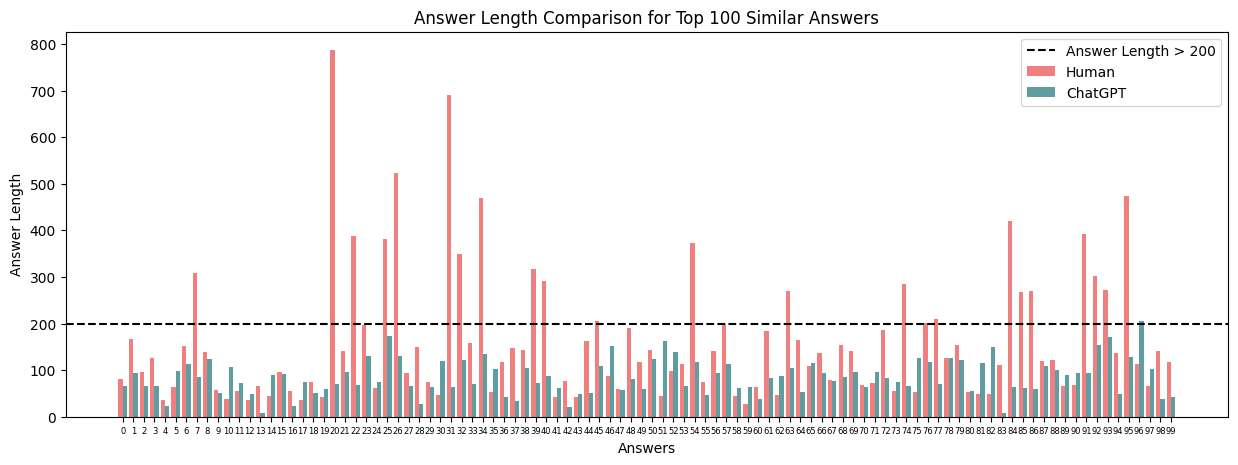

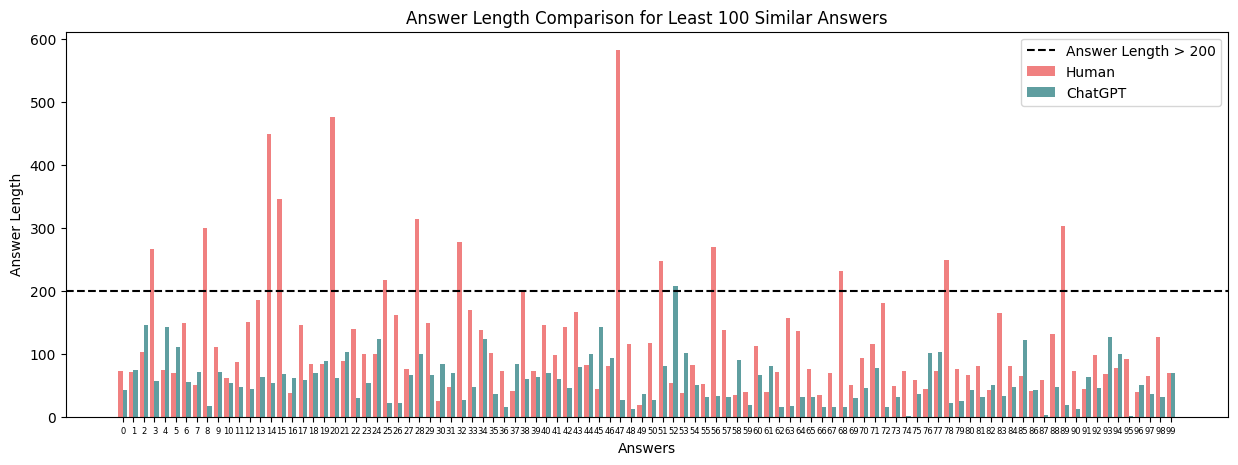

In [225]:
top100_h_len = []
top100_c_len = []
for i in range(len(top100_df)):
    top100_h_len.append(len(set(top100_df['Human Answer'][i].split())))
    top100_c_len.append(len(set(top100_df['ChatGPT Answer'][i].split())))

X_axis = np.arange(len(top100_df))

plt.figure(figsize=(15,5))
plt.bar(X_axis - 0.2, top100_h_len, 0.4, label = 'Human', color = 'lightcoral')
plt.bar(X_axis + 0.2, top100_c_len, 0.4, label = 'ChatGPT', color = 'cadetblue')

plt.xticks(X_axis, fontsize = 6)
plt.xlabel("Answers")
plt.ylabel("Answer Length")
plt.title("Answer Length Comparison for Top 100 Similar Answers")
plt.axhline(y = 200, linestyle = '--', color = 'black', label = 'Answer Length > 200')
plt.legend()
plt.show()

print('\n\n')

low100_h_len = []
low100_c_len = []
for i in range(len(low100_df)):
    low100_h_len.append(len(set(low100_df['Human Answer'][i].split())))
    low100_c_len.append(len(set(low100_df['ChatGPT Answer'][i].split())))
    
X_axis = np.arange(len(low100_df))

plt.figure(figsize=(15,5))
plt.bar(X_axis - 0.2, low100_h_len, 0.4, label = 'Human', color = 'lightcoral')
plt.bar(X_axis + 0.2, low100_c_len, 0.4, label = 'ChatGPT', color = 'cadetblue')

plt.xticks(X_axis, fontsize = 6)
plt.xlabel("Answers")
plt.ylabel("Answer Length")
plt.title("Answer Length Comparison for Least 100 Similar Answers")
plt.axhline(y = 200, linestyle = '--', color = 'black', label = 'Answer Length > 200')
plt.legend()
plt.show()

In [227]:
top100_ratio_list = []
for i in range(len(top100_h_len)):
    top100_ratio_list.append(max(top100_h_len[i], top100_c_len[i]) / min(top100_h_len[i], top100_c_len[i]))
labels = range(len(top100_df))

low100_ratio_list = []
for i in range(len(low100_h_len)):
    low100_ratio_list.append(max(low100_h_len[i], low100_c_len[i]) / min(low100_h_len[i], low100_c_len[i]))
labels = range(len(low100_df))

print(f'Average Ratio of Human Answer to ChatGPT answer for Most Similar Answers: {np.mean(top100_ratio_list)}\n')
print(f'Average Ratio of Human Answer to ChatGPT answer for Least Similar Answers: {np.mean(low100_ratio_list)}\n')

Average Ratio of Human Answer to ChatGPT answer for Most Similar Answers: 2.5629570127071997

Average Ratio of Human Answer to ChatGPT answer for Least Similar Answers: 5.445368507242911



#### Comparison of Sentiment for Most Similar and Least Similar Answers

In [247]:
sia = SentimentIntensityAnalyzer()

top100_h_scores = []
top100_h_scores = top100_df['Human Answer'].apply(lambda x: sia.polarity_scores(x))

top100_c_scores = []
top100_c_scores = top100_df['ChatGPT Answer'].apply(lambda x: sia.polarity_scores(x))


low100_h_scores = []
low100_h_scores = low100_df['Human Answer'].apply(lambda x: sia.polarity_scores(x))

low100_c_scores = []
low100_c_scores = low100_df['ChatGPT Answer'].apply(lambda x: sia.polarity_scores(x))

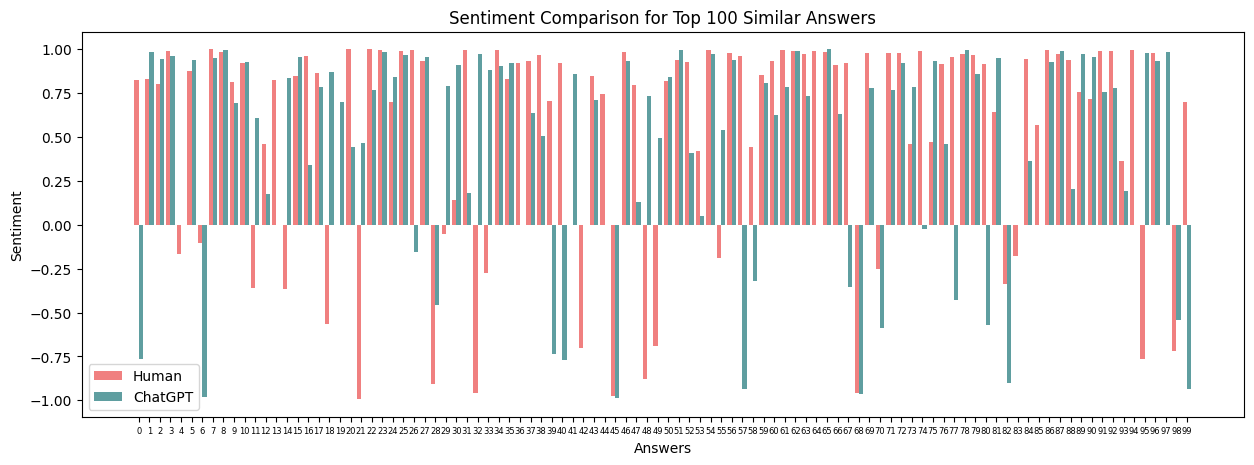

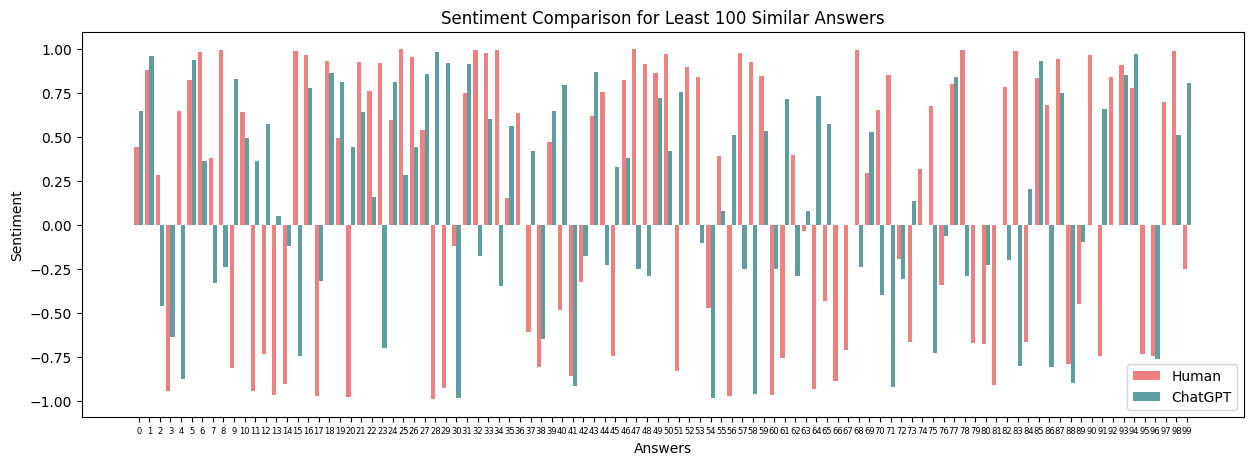

In [252]:
top100_comp_score_h = [score['compound'] for score in top100_h_scores]
top100_comp_score_c = [score['compound'] for score in top100_c_scores]

low100_comp_score_h = [score['compound'] for score in low100_h_scores]
low100_comp_score_c = [score['compound'] for score in low100_c_scores]

X_axis = np.arange(len(top100_comp_score_h))

plt.figure(figsize=(15,5))
plt.bar(X_axis - 0.2, top100_comp_score_h, 0.4, label = 'Human', color = 'lightcoral')
plt.bar(X_axis + 0.2, top100_comp_score_c, 0.4, label = 'ChatGPT', color = 'cadetblue')

plt.xticks(X_axis, fontsize = 6)
plt.xlabel("Answers")
plt.ylabel("Sentiment")
plt.title("Sentiment Comparison for Top 100 Similar Answers")
plt.legend()
plt.show()

print('\n\n')

X_axis = np.arange(len(low100_comp_score_h))

plt.figure(figsize=(15,5))
plt.bar(X_axis - 0.2, low100_comp_score_h, 0.4, label = 'Human', color = 'lightcoral')
plt.bar(X_axis + 0.2, low100_comp_score_c, 0.4, label = 'ChatGPT', color = 'cadetblue')

plt.xticks(X_axis, fontsize = 6)
plt.xlabel("Answers")
plt.ylabel("Sentiment")
plt.title("Sentiment Comparison for Least 100 Similar Answers")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Distribution of Compound Score ChatGPT for Least 100 Similar Answers')

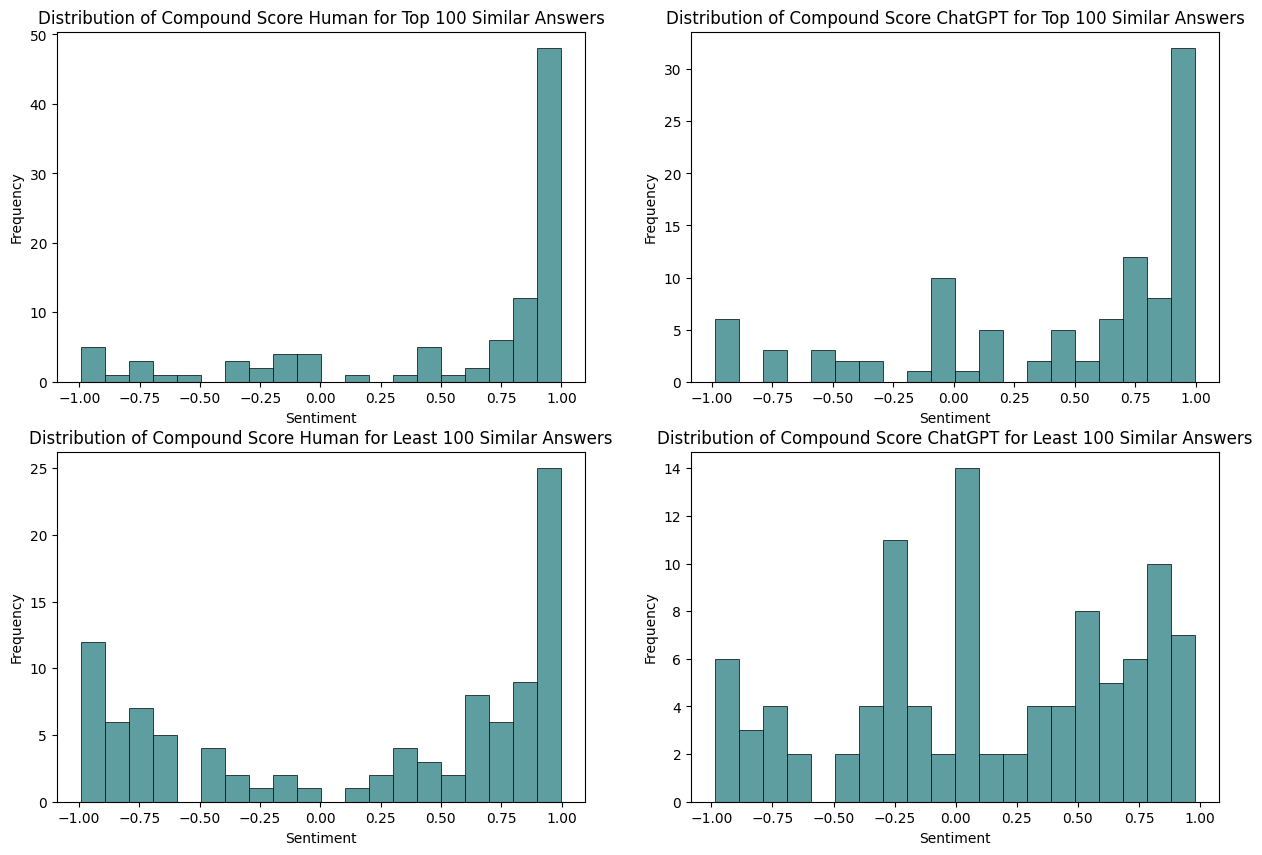

In [264]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Compound Score Human for Top 100 Similar Answers
axes[0,0].hist(top100_comp_score_h, bins= 20, facecolor='cadetblue', edgecolor='black', linewidth=0.5)
axes[0,0].set_xlabel('Sentiment')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Distribution of Compound Score Human for Top 100 Similar Answers')

# Compound Score ChatGPT for Top 100 Similar Answers
axes[0,1].hist(top100_comp_score_c, bins= 20, facecolor='cadetblue', edgecolor='black', linewidth=0.5)
axes[0,1].set_xlabel('Sentiment')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Distribution of Compound Score ChatGPT for Top 100 Similar Answers')

# Compound Score Human for Least 100 Similar Answers
axes[1,0].hist(low100_comp_score_h, bins= 20, facecolor='cadetblue', edgecolor='black', linewidth=0.5)
axes[1,0].set_xlabel('Sentiment')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Distribution of Compound Score Human for Least 100 Similar Answers')

# Compound Score ChatGPT for Least 100 Similar Answers
axes[1,1].hist(low100_comp_score_c, bins= 20, facecolor='cadetblue', edgecolor='black', linewidth=0.5)
axes[1,1].set_xlabel('Sentiment')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Distribution of Compound Score ChatGPT for Least 100 Similar Answers')

#### Comparison of Grammar Mistakes of Most Similar and Least Similar Answers

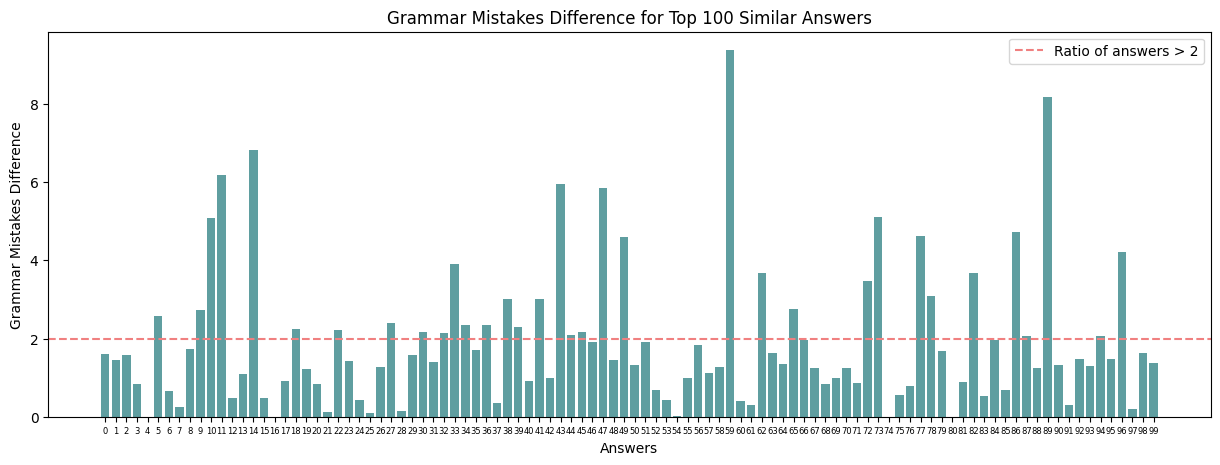

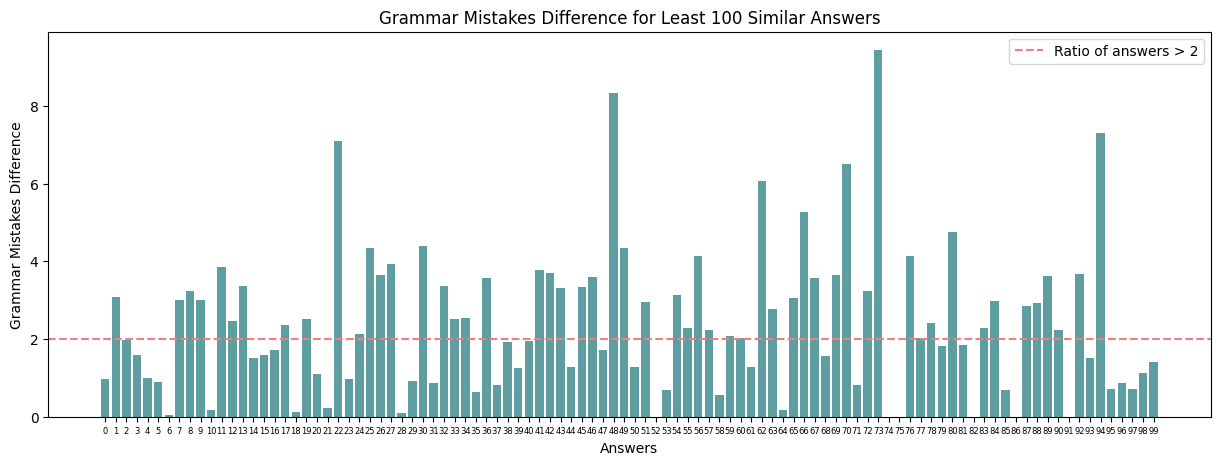

In [280]:
top100_gram_mist_h = gram_mistakes([ans.split() for ans in top100_df['Human Answer']])
top100_gram_mist_c = gram_mistakes([ans.split() for ans in top100_df['ChatGPT Answer']])

low100_gram_mist_h = gram_mistakes([ans.split() for ans in low100_df['Human Answer']])
low100_gram_mist_c = gram_mistakes([ans.split() for ans in low100_df['ChatGPT Answer']])

top100_diff_list = []
for i in range(len(top100_gram_mist_h)):
    top100_diff_list.append(abs(top100_gram_mist_h[i] - top100_gram_mist_c[i]))
labels = range(len(top100_df))

low100_diff_list = []
for i in range(len(low100_gram_mist_h)):
    low100_diff_list.append(abs(low100_gram_mist_h[i] - low100_gram_mist_c[i]))
labels = range(len(low100_df))


plt.figure(figsize=(15,5))
plt.bar(labels, top100_diff_list, color = 'cadetblue');
plt.title("Grammar Mistakes Difference for Top 100 Similar Answers");
plt.xlabel("Answers");
plt.ylabel("Grammar Mistakes Difference");
plt.xticks(labels, fontsize = 6);
plt.axhline(y = 2, linestyle = '--', color = 'lightcoral', label = 'Ratio of answers > 2');
plt.legend();
plt.show();
print('\n\n')

plt.figure(figsize=(15,5))
plt.bar(labels, low100_diff_list, color = 'cadetblue');
plt.title("Grammar Mistakes Difference for Least 100 Similar Answers");
plt.xlabel("Answers");
plt.ylabel("Grammar Mistakes Difference");
plt.xticks(labels, fontsize = 6);
plt.axhline(y = 2, linestyle = '--', color = 'lightcoral', label = 'Ratio of answers > 2');
plt.legend();
plt.show();

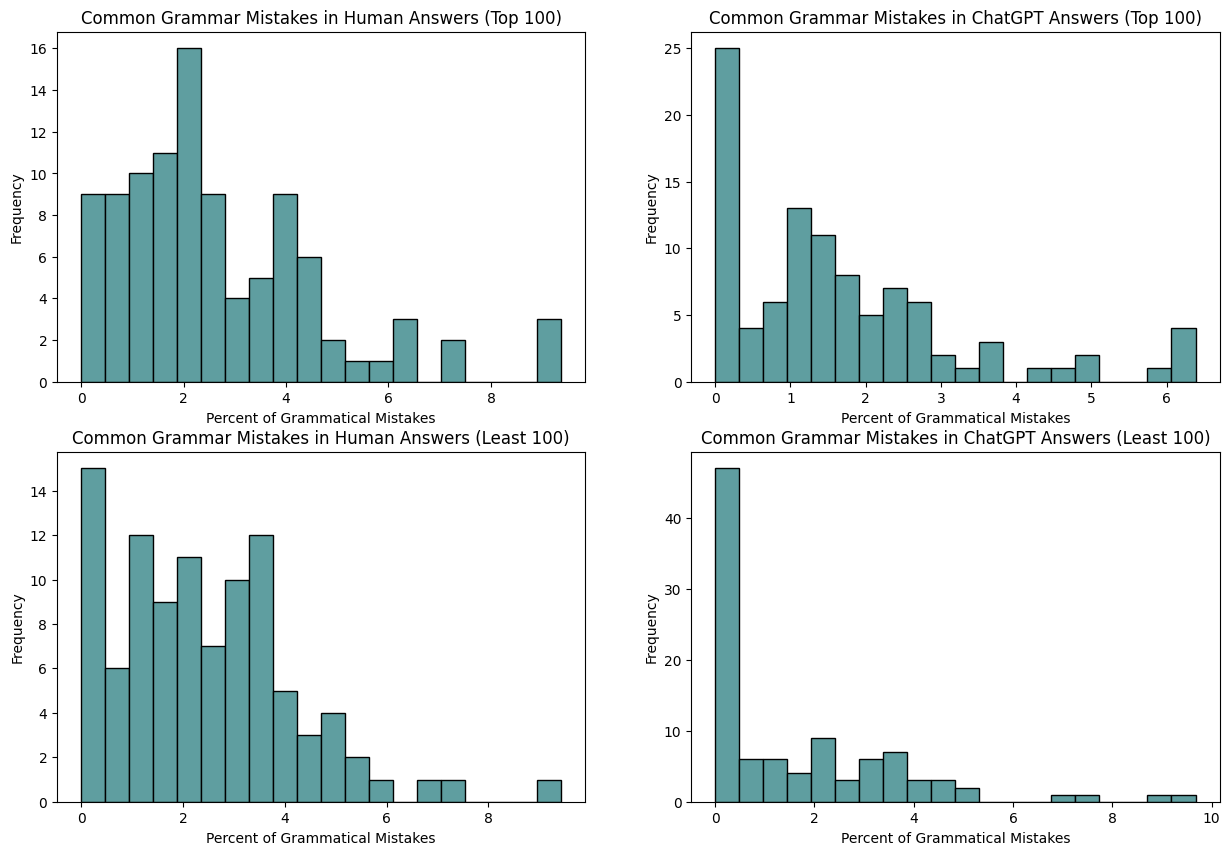

In [306]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Grammar Mistakes Human
axes[0,0].hist(top100_gram_mist_h, bins= 20, facecolor='cadetblue', edgecolor='black');
axes[0,0].set_xlabel('Percent of Grammatical Mistakes');
axes[0,0].set_ylabel('Frequency');
axes[0,0].set_title('Common Grammar Mistakes in Human Answers (Top 100)');

# Grammar Mistakes ChatGPT
axes[0,1].hist(top100_gram_mist_c, bins= 20, facecolor='cadetblue', edgecolor='black');
axes[0,1].set_xlabel('Percent of Grammatical Mistakes');
axes[0,1].set_ylabel('Frequency');
axes[0,1].set_title('Common Grammar Mistakes in ChatGPT Answers (Top 100)');

# Grammar Mistakes Human
axes[1,0].hist(low100_gram_mist_h, bins= 20, facecolor='cadetblue', edgecolor='black');
axes[1,0].set_xlabel('Percent of Grammatical Mistakes');
axes[1,0].set_ylabel('Frequency');
axes[1,0].set_title('Common Grammar Mistakes in Human Answers (Least 100)');

# Grammar Mistakes ChatGPT
axes[1,1].hist(low100_gram_mist_c, bins= 20, facecolor='cadetblue', edgecolor='black');
axes[1,1].set_xlabel('Percent of Grammatical Mistakes');
axes[1,1].set_ylabel('Frequency');
axes[1,1].set_title('Common Grammar Mistakes in ChatGPT Answers (Least 100)');